# Lecture 4
### Peru (BCRPData API)
- **FX**: Interbank USD/PEN (buy) vs SBS banking system USD/PEN (buy)
- **Commodities**: Gold and Copper reference prices (daily series published by BCRP)

### USA (Yahoo Finance via `yfinance`)
- **Market**: SPY (US equities), TLT (US long bonds), GLD (gold ETF)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [28]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 0) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [29]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()


Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


## 1) Quantities

### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

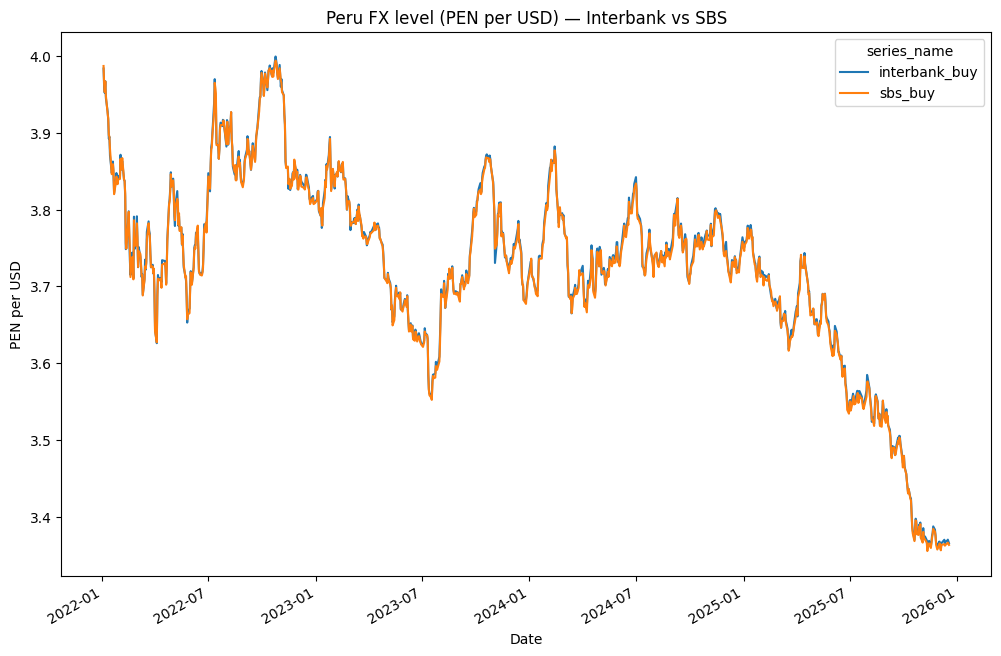

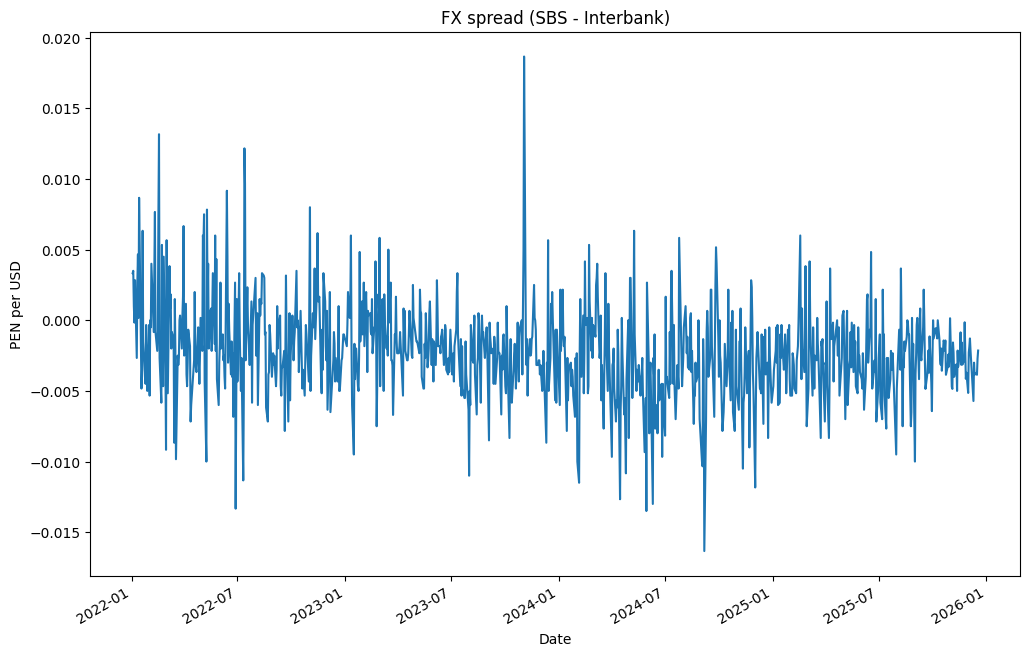

FX wide rows: 988


series_name,interbank_buy,sbs_buy,spread
date,,,
2022-01-03,3.983667,3.987,0.003333
2022-01-04,3.959500,3.963,0.003500
2022-01-05,3.952000,3.953,0.001000
2022-01-06,3.967167,3.967,-0.000167
2022-01-07,3.945167,3.948,0.002833


In [30]:
if peru.shape[0] == 0:
    print("Peru data is empty (BCRPData unavailable).")
else:
    df = peru.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 1 Filter to the two FX series (robust to Spanish/English names)
    name = df["series_name"].astype(str).str.lower()

    fx_hint = name.str.contains("tipo de cambio") | name.str.contains("exchange rate") | name.str.contains("tc ")
    interbank_mask = fx_hint & (name.str.contains("interbanc") | name.str.contains("interbank"))
    sbs_mask       = fx_hint & (name.str.contains("sbs"))

    fx = df[interbank_mask | sbs_mask].dropna(subset=["date"]).copy()

    if fx.shape[0] == 0:
        print("Could not detect FX series in `peru`. Check `peru['series_name'].unique()`.")
    else:
        # Keep only date/series/value and ensure numeric
        fx["value"] = pd.to_numeric(fx["value"], errors="coerce")
        fx = fx.dropna(subset=["value"])

        # Identify the exact column names found
        interbank_names = fx.loc[interbank_mask[fx.index], "series_name"].unique()
        sbs_names       = fx.loc[sbs_mask[fx.index], "series_name"].unique()

        if len(interbank_names) == 0 or len(sbs_names) == 0:
            print("Detected FX rows, but could not separate Interbank vs SBS cleanly.")
            print("Series found:\n", fx["series_name"].value_counts())
        else:
            interbank_name = interbank_names[0]
            sbs_name = sbs_names[0]

            # 2 Pivot to wide format (date as index)
            fx_wide = (
                fx.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
                  .sort_index()
            )

            # Rename to clean column names
            fx_wide = fx_wide.rename(columns={
                interbank_name: "interbank_buy",
                sbs_name: "sbs_buy",
            })

            # Drop rows where both are missing
            fx_wide = fx_wide.dropna(subset=["interbank_buy", "sbs_buy"], how="all")

            # 3 Plot both FX levels in the same line chart
            ax = fx_wide[["interbank_buy", "sbs_buy"]].plot(title="Peru FX level (PEN per USD) — Interbank vs SBS")
            ax.set_xlabel("Date")
            ax.set_ylabel("PEN per USD")
            plt.show()

            # 4 Create spread = sbs - interbank and plot it separately
            fx_wide["spread"] = fx_wide["sbs_buy"] - fx_wide["interbank_buy"]

            ax2 = fx_wide["spread"].plot(title="FX spread (SBS - Interbank)")
            ax2.set_xlabel("Date")
            ax2.set_ylabel("PEN per USD")
            plt.show()

            # Optional: quick sanity check
            print("FX wide rows:", fx_wide.shape[0])
            display(fx_wide.head())


## 2) Proportions

### Exercise 2.1 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

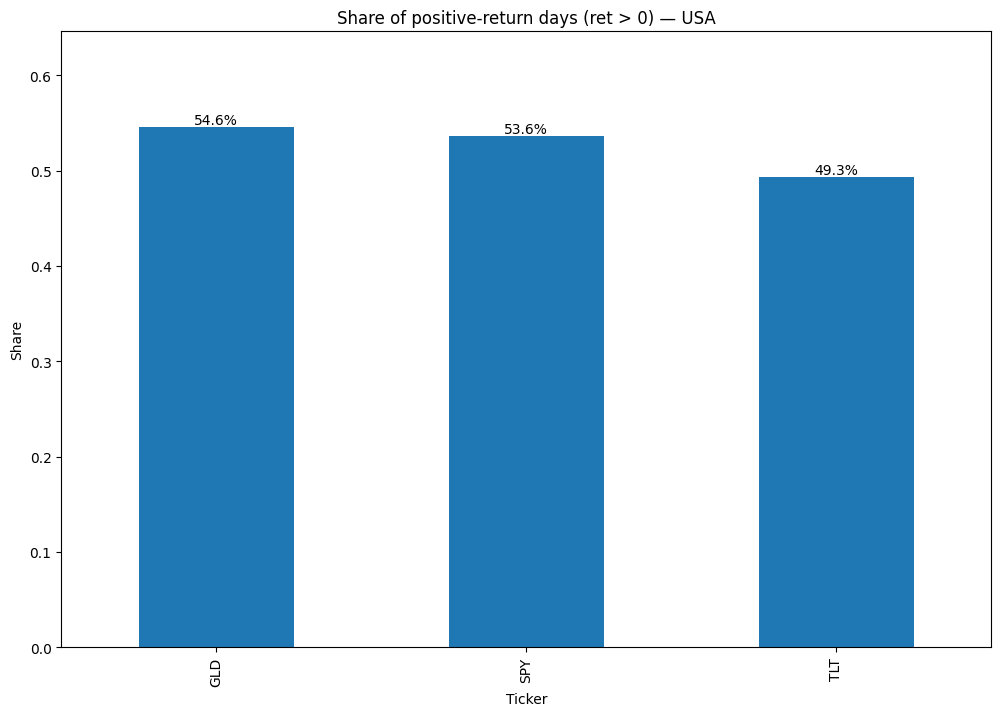

,share_positive
ticker,
GLD,0.545821
SPY,0.535750
TLT,0.493454


In [31]:
if usa.shape[0] == 0:
    # If the USA dataset has zero rows, it means we couldn't download data (or it's empty).
    print("USA data is empty (yfinance unavailable).")
else:
    # Make a copy so we don't modify the original `usa` DataFrame.
    df = usa.copy()
    # Convert the 'date' column to pandas datetime (invalid parses become NaT).
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Ensure the return column `ret` exists (or compute it if it is missing / all NaN).
    if "ret" not in df.columns or df["ret"].isna().all():
        # Sort by ticker then date so returns are computed in chronological order per ticker.
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

        # Compute daily percent change in 'close' for each ticker group.
        # The first observation per ticker will have NaN return by definition.
        df["ret"] = df.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)
    # 1 Compute the share of days with positive returns (ret > 0) for each ticker.
    shares = (
        # Drop rows where ret is missing (e.g., first day per ticker).
        df.dropna(subset=["ret"])
          # Group the data by ticker.
          .groupby("ticker")["ret"]
          # For each ticker, compute the fraction of days where ret is strictly positive.
          .apply(lambda s: (s > 0).mean())
          # Sort tickers from highest to lowest positive-day share.
          .sort_values(ascending=False)
    )
    # 2 Create a bar chart of the shares.
    ax = shares.plot(kind="bar", title="Share of positive-return days (ret > 0) — USA")
    # Set x-axis label.
    ax.set_xlabel("Ticker")
    # Set y-axis label.
    ax.set_ylabel("Share")
    # 3 Add percentage labels on top of each bar.
    for p in ax.patches:
        # Get the bar height (the share value).
        h = p.get_height()

        # Write the label at the top center of the bar (formatted as percent with 1 decimal).
        ax.annotate(
            f"{h:.1%}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=10
        )
    # Set the y-axis limit: start at 0 and leave ~10% headroom above the max share.
    ax.set_ylim(0, min(1.0, float(shares.max()) + 0.10))
    # Display the plot.
    plt.show()
    # Display the shares as a one-column DataFrame named 'share_positive'.
    display(shares.rename("share_positive").to_frame())

## 3) Distributions

### Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

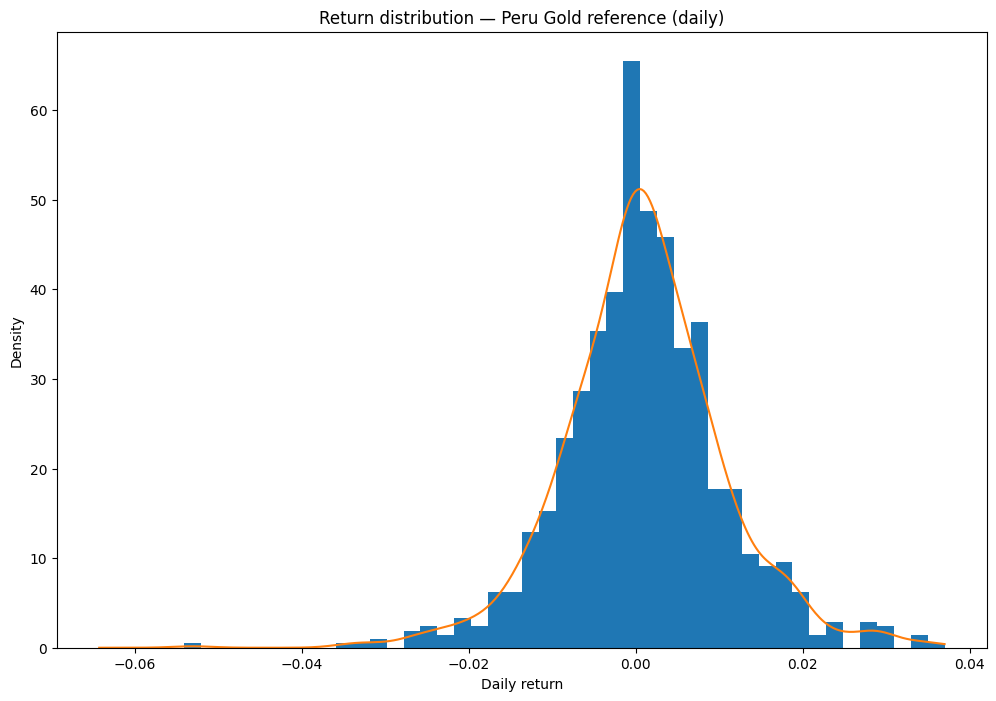

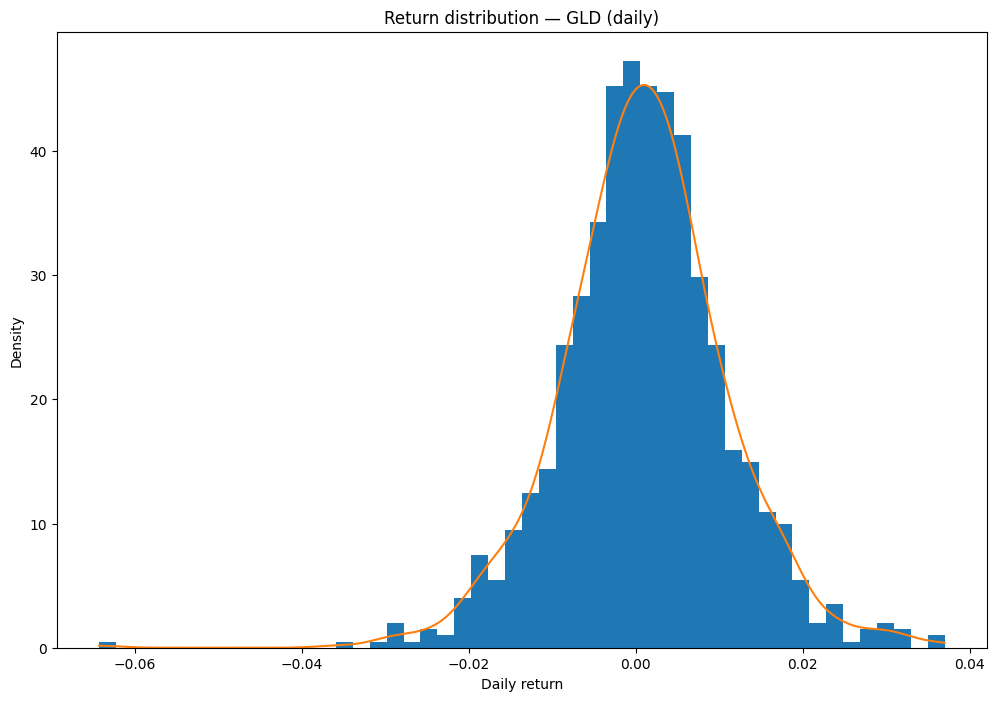

Peru gold return obs: 1033 | GLD return obs: 993


In [32]:
try:
    # Try to import KDE function from SciPy (optional dependency)
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True  # flag: we can plot KDE
except Exception:
    HAS_SCIPY = False  # flag: SciPy not available, skip KDE
# If either Peru or USA dataset is empty, we cannot run the exercise
if peru.shape[0] == 0 or usa.shape[0] == 0:
    print("Missing Peru or USA data.")
else:
    # 1 Peru: build daily gold series and compute returns


    p = peru.copy()  # copy to avoid modifying the original DataFrame
    p["date"] = pd.to_datetime(p["date"], errors="coerce")  # ensure date is datetime

    # Create a lowercased version of the series name for robust text matching
    sname = p["series_name"].astype(str).str.lower()

    # Identify gold rows by searching for "oro" (Spanish) or "gold" (English)
    gold_mask = sname.str.contains("oro") | sname.str.contains("gold")
    gold_peru = (
        p[gold_mask][["date", "value"]]
          .dropna(subset=["date"])
          .assign(value=lambda d: pd.to_numeric(d["value"], errors="coerce"))
          .dropna(subset=["value"])
          .sort_values("date")
          .groupby("date", as_index=False)["value"].last()
          .rename(columns={"value": "gold_peru"})
    )

    # Compute daily returns for Peru gold (percent change)
    gold_peru["ret"] = pct_change(gold_peru["gold_peru"])

    # Keep only non-missing returns
    gold_peru_ret = gold_peru["ret"].dropna()
    # 2 USA: filter to GLD returns

    u = usa.copy()  # copy to avoid modifying the original DataFrame
    u["date"] = pd.to_datetime(u["date"], errors="coerce")  # ensure date is datetime

    # If returns are missing (or all NaN), compute returns per ticker from close prices
    if "ret" not in u.columns or u["ret"].isna().all():
        u = u.sort_values(["ticker", "date"]).reset_index(drop=True)  # sort for correct pct_change
        u["ret"] = u.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Extract GLD returns and drop missing values
    gld_ret = u.loc[u["ticker"] == "GLD", "ret"].dropna()
    # 3 Same binning for both histograms

    # Combine both return series to compute shared bin edges
    all_ret = pd.concat([gold_peru_ret, gld_ret], ignore_index=True).replace([np.inf, -np.inf], np.nan).dropna()

    # If everything is missing after cleaning, stop
    if all_ret.shape[0] == 0:
        print("No returns available after cleaning.")
    else:
        # Compute common bin edges so both histograms use the same bins
        bin_edges = np.histogram_bin_edges(all_ret.values, bins=50)
        # 3. Histogram: Peru Gold returns
        
        plt.figure()  # create a new figure
        plt.hist(gold_peru_ret.values, bins=bin_edges, density=True)  # histogram with shared bins, normalized
        plt.title("Return distribution — Peru Gold reference (daily)")  # figure title
        plt.xlabel("Daily return")  # x-axis label
        plt.ylabel("Density")  # y-axis label
        # 4 Optional KDE overlay (only if SciPy exists and enough observations)
        
        if HAS_SCIPY and gold_peru_ret.shape[0] > 5:
            xs = np.linspace(bin_edges[0], bin_edges[-1], 400)  # x-grid for smooth curve
            kde = gaussian_kde(gold_peru_ret.values)  # fit KDE on Peru gold returns
            plt.plot(xs, kde(xs))  # plot KDE curve

        plt.show()  # display the Peru gold histogram figure
        # 3. Histogram: GLD returns

        plt.figure()  # create a new figure
        plt.hist(gld_ret.values, bins=bin_edges, density=True)  # histogram with same bins, normalized
        plt.title("Return distribution — GLD (daily)")  # figure title
        plt.xlabel("Daily return")  # x-axis label
        plt.ylabel("Density")  # y-axis label

        # 4 Optional KDE overlay (only if SciPy exists and enough observations)
        if HAS_SCIPY and gld_ret.shape[0] > 5:
            xs = np.linspace(bin_edges[0], bin_edges[-1], 400)  # x-grid for smooth curve
            kde = gaussian_kde(gld_ret.values)  # fit KDE on GLD returns
            plt.plot(xs, kde(xs))  # plot KDE curve

        plt.show()  # display the GLD histogram figure

        # Print number of non-missing return observations used in each series
        print("Peru gold return obs:", gold_peru_ret.shape[0], "| GLD return obs:", gld_ret.shape[0])


## 4) Relationships

### Exercise 4.1 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

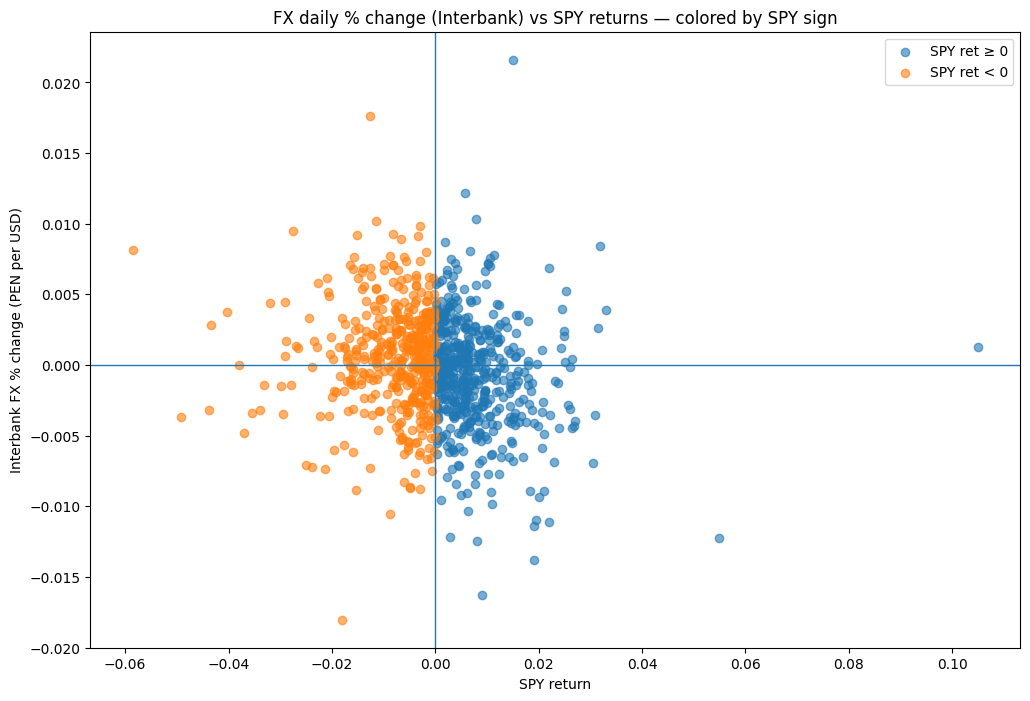

Correlation (SPY ret, FX ret): -0.17340345852249253
Merged obs: 956


,date,spy_ret,fx_ret
0,2022-01-04,-0.000335,-0.006066
1,2022-01-05,-0.019202,-0.001894
2,2022-01-06,-0.000939,0.003838
3,2022-01-07,-0.003954,-0.005546
4,2022-01-10,-0.001244,-0.004436


In [33]:
if peru.shape[0] == 0 or usa.shape[0] == 0:
    print("Missing Peru or USA data.")
else:
    # 1 Interbank FX daily returns (Peru)


    p = peru.copy()  # copy to avoid modifying the original `peru`
    p["date"] = pd.to_datetime(p["date"], errors="coerce")  # ensure date is datetime
    sname = p["series_name"].astype(str).str.lower()  # lowercase series names for robust matching

    fx_hint = (
        sname.str.contains("tipo de cambio")    
        | sname.str.contains("exchange rate")     
        | sname.str.contains("tc ")               
    )
    # Interbank series = "exchange rate" + ("interbanc" or "interbank")
    interbank_mask = fx_hint & (sname.str.contains("interbanc") | sname.str.contains("interbank"))
    fx_ib = (
        p[interbank_mask][["date", "value"]]
          .dropna(subset=["date"])
          .assign(value=lambda d: pd.to_numeric(d["value"], errors="coerce"))
          .dropna(subset=["value"])
          .sort_values("date")
          .groupby("date", as_index=False)["value"].last()
          .rename(columns={"value": "fx_interbank"})
    )

    # Compute daily percent change for the Interbank FX level
    fx_ib["fx_ret"] = pct_change(fx_ib["fx_interbank"])

    # Drop rows where FX return is missing (first day has NaN return)
    fx_ib = fx_ib.dropna(subset=["fx_ret"])

    # 2 SPY daily returns (USA)


    u = usa.copy()  # copy to avoid modifying the original `usa`
    u["date"] = pd.to_datetime(u["date"], errors="coerce")  # ensure date is datetime

    # If `ret` column does not exist (or is all NaN), compute returns from close prices
    if "ret" not in u.columns or u["ret"].isna().all():
        # Sort by ticker and date so percent changes are computed in correct time order
        u = u.sort_values(["ticker", "date"]).reset_index(drop=True)

        # Compute daily returns by ticker (close-to-close percent change)
        u["ret"] = u.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Extract SPY returns only, keep date and ret, and rename ret -> spy_ret
    spy = (
        u[u["ticker"] == "SPY"][["date", "ret"]]
          .dropna(subset=["date", "ret"])          # remove missing dates/returns
          .rename(columns={"ret": "spy_ret"})      # rename column for clarity
          .sort_values("date")                     # sort chronologically
    )
    # 3 Merge on date

    # Merge SPY returns with Interbank FX returns using the intersection of dates (inner join)
    merged = pd.merge(spy, fx_ib[["date", "fx_ret"]], on="date", how="inner").dropna()

    # If no dates overlap after merging, stop
    if merged.shape[0] == 0:
        print("No overlapping dates after merge.")
    else:
        # Create boolean masks for positive vs negative SPY return days (for coloring)
        pos = merged["spy_ret"] >= 0  # SPY non-negative return days
        neg = ~pos                   # SPY negative return days

        # Create a new scatter plot figure
        plt.figure()

        # Plot points for SPY >= 0 in one color (matplotlib picks default)
        plt.scatter(
            merged.loc[pos, "spy_ret"],
            merged.loc[pos, "fx_ret"],
            label="SPY ret ≥ 0",
            alpha=0.6
        )

        # Plot points for SPY < 0 in a different color
        plt.scatter(
            merged.loc[neg, "spy_ret"],
            merged.loc[neg, "fx_ret"],
            label="SPY ret < 0",
            alpha=0.6
        )

        # Add horizontal and vertical reference lines at zero
        plt.axhline(0, linewidth=1)
        plt.axvline(0, linewidth=1)

        # Add title and axis labels
        plt.title("FX daily % change (Interbank) vs SPY returns — colored by SPY sign")
        plt.xlabel("SPY return")
        plt.ylabel("Interbank FX % change (PEN per USD)")

        # Show legend and display the plot
        plt.legend()
        plt.show()
        # 5 Correlation + quick summary

        # Compute Pearson correlation between SPY returns and FX returns
        corr = merged["spy_ret"].corr(merged["fx_ret"])

        # Print the correlation value
        print("Correlation (SPY ret, FX ret):", corr)

        # Print number of merged observations (overlapping dates)
        print("Merged obs:", merged.shape[0])

        # Display first few rows of the merged dataset for sanity checking
        display(merged.head())


## 5) References 

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

Load data same sources as Lecture 

Peru — BCRPData series codes:
- **PD04637PD**: Interbank FX USD/PEN (buy)
- **PD04639PD**: SBS banking system FX USD/PEN (buy)
- **PD04704XD**: Gold reference price
- **PD04701XD**: Copper reference price

USA — Yahoo tickers:
- **SPY**, **TLT**, **GLD**

In [34]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()


Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


## 1) Pandas

### Exercise 1.1 — Series (SPY)
Build a `pandas.Series` for SPY close prices and practice core Series methods.

**Tasks**
1. From `usa`, create a Series `spy_close` indexed by date.
2. Show: `head`, `tail`, `describe`.
3. Compute daily returns (`spy_ret`) and count how many missing values it has.
4. Find the 5 largest absolute daily returns.

In [35]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    df = usa.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 1 Create a Series spy_close indexed by date
    spy_close = (
        df[df["ticker"] == "SPY"][["date", "close"]]
          .dropna(subset=["date", "close"])
          .sort_values("date")
          .set_index("date")["close"]
          .astype(float)
    )

    # 2 Show head, tail, describe
    print("spy_close.head():")
    display(spy_close.head())

    print("\nspy_close.tail():")
    display(spy_close.tail())

    print("\nspy_close.describe():")
    display(spy_close.describe())

    # 3 Compute daily returns and count missing values
    spy_ret = spy_close.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
    print("\nMissing values in spy_ret:", int(spy_ret.isna().sum()))

    # 4 Find the 5 largest absolute daily returns
    top5_abs = spy_ret.abs().nlargest(5)
    print("\nTop 5 absolute daily returns (magnitude):")
    display(top5_abs)

    print("\nTop 5 absolute daily returns (signed):")
    display(spy_ret.loc[top5_abs.index])

spy_close.head():


date
2022-01-03    477.709991
2022-01-04    477.549988
2022-01-05    468.380005
2022-01-06    467.940002
2022-01-07    466.089996
Name: close, dtype: float64


spy_close.tail():


date
2025-12-11    689.169983
2025-12-12    681.760010
2025-12-15    680.729980
2025-12-16    678.869995
2025-12-17    671.400024
Name: close, dtype: float64


spy_close.describe():


count    994.000000
mean     497.719920
std       91.598825
min      356.559998
25%      414.522507
50%      472.675003
75%      576.557510
max      689.169983
Name: close, dtype: float64


Missing values in spy_ret: 1

Top 5 absolute daily returns (magnitude):


date
2025-04-09    0.105019
2025-04-04    0.058543
2022-11-10    0.054954
2025-04-03    0.049281
2025-04-10    0.043819
Name: close, dtype: float64


Top 5 absolute daily returns (signed):


date
2025-04-09    0.105019
2025-04-04   -0.058543
2022-11-10    0.054954
2025-04-03   -0.049281
2025-04-10   -0.043819
Name: close, dtype: float64

### Exercise 1.2 — DataFrame selection (position vs condition)
Practice `.iloc`, `.loc`, boolean filters, and `query`.

**Tasks**
1. Create a DataFrame `us_sub` that contains only SPY and GLD.
2. Using `.iloc`, select rows 10–20 and columns `[date, ticker, close, ret]`.
3. Using a condition, keep only days where `ticker == 'SPY'` and `ret > 0.01`.
4. Confirm the number of rows matches between boolean indexing and `.query`.

In [36]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    # Make a copy so we do not modify the original DataFrame
    df = usa.copy()

    # Ensure 'date' is datetime for clean filtering/sorting
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # If 'ret' is missing or all NaN, compute daily returns per ticker from close prices
    if "ret" not in df.columns or df["ret"].isna().all():
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
        df["ret"] = df.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # 1 Create `us_sub` containing only SPY and GLD
    us_sub = df[df["ticker"].isin(["SPY", "GLD"])].copy()

    # Keep only the columns we care about (and in a clean order)
    us_sub = us_sub[["date", "ticker", "close", "ret"]].dropna(subset=["date"])

    # Sort so iloc row positions are deterministic and reproducible
    us_sub = us_sub.sort_values(["ticker", "date"]).reset_index(drop=True)

    # 2 Using `.iloc`, select rows 10–20 and the 4 columns [date, ticker, close, ret]
    # Note: iloc uses 0-based indexing and the end is exclusive, so 10:21 gives rows 10..20
    us_iloc = us_sub.iloc[10:21, :]

    # 3 Using a condition, keep only days where ticker == 'SPY' and ret > 0.01
    # Boolean indexing approach
    spy_gt_1pct_bool = us_sub[(us_sub["ticker"] == "SPY") & (us_sub["ret"] > 0.01)]

    # Same filter using `.query`
    spy_gt_1pct_query = us_sub.query("ticker == 'SPY' and ret > 0.01")

    # 4 Confirm the number of rows matches between boolean indexing and `.query`
    same_n = (spy_gt_1pct_bool.shape[0] == spy_gt_1pct_query.shape[0])

    print("us_sub rows:", us_sub.shape[0])
    print("iloc rows 10–20 shape:", us_iloc.shape)
    print("SPY ret > 1% (boolean) rows:", spy_gt_1pct_bool.shape[0])
    print("SPY ret > 1% (query) rows:", spy_gt_1pct_query.shape[0])
    print("Do the counts match?", same_n)

    # Display results (optional but helpful)
    display(us_sub.head())
    display(us_iloc)
    display(spy_gt_1pct_bool.head())


us_sub rows: 1988
iloc rows 10–20 shape: (11, 4)
SPY ret > 1% (boolean) rows: 146
SPY ret > 1% (query) rows: 146
Do the counts match? True


,date,ticker,close,ret
0,2022-01-03,GLD,168.330002,NaN
1,2022-01-04,GLD,169.570007,0.007367
2,2022-01-05,GLD,169.059998,-0.003008
3,2022-01-06,GLD,166.990005,-0.012244
4,2022-01-07,GLD,167.750000,0.004551


,date,ticker,close,ret
10,2022-01-18,GLD,169.389999,-0.001650
11,2022-01-19,GLD,172.080002,0.015881
12,2022-01-20,GLD,171.649994,-0.002499
13,2022-01-21,GLD,171.089996,-0.003262
14,2022-01-24,GLD,172.029999,0.005494
15,2022-01-25,GLD,172.580002,0.003197
16,2022-01-26,GLD,169.789993,-0.016166
17,2022-01-27,GLD,167.600006,-0.012898
18,2022-01-28,GLD,167.100006,-0.002983
19,2022-01-31,GLD,168.089996,0.005925


,date,ticker,close,ret
1012,2022-01-28,SPY,441.950012,0.024835
1013,2022-01-31,SPY,449.910004,0.018011
1020,2022-02-09,SPY,457.540009,0.014636
1024,2022-02-15,SPY,446.100006,0.016127
1030,2022-02-24,SPY,428.299988,0.015049


### Exercise 1.3 — Apply method (rolling volatility)
Use `groupby` and `apply` to compute rolling volatility.

**Tasks**
1. For each USA ticker, compute 20-day rolling volatility of returns:
   `vol20 = ret.rolling(20).std()`
2. Store it as a new column `vol20`.
3. Report the last available `vol20` for each ticker.

In [37]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    # Make a copy so we do not modify the original DataFrame
    df = usa.copy()

    # Ensure the date column is datetime for correct sorting and rolling calculations
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # If returns are missing (or all NaN), compute daily returns per ticker from close prices
    if "ret" not in df.columns or df["ret"].isna().all():
        # Sort by ticker and date so pct_change is computed in time order
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

        # Compute close-to-close daily returns within each ticker group
        df["ret"] = df.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Sort again to be safe (rolling requires correct time ordering)
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # 1  For each ticker, compute 20-day rolling standard deviation of returns
    #    - groupby("ticker") ensures we compute rolling volatility separately per ticker
    #    - rolling(20).std() computes the rolling volatility using a 20-day window
    df["vol20"] = (
        df.groupby("ticker")["ret"]
          .apply(lambda s: s.rolling(20).std())
          .reset_index(level=0, drop=True)
    )

    # 2 vol20 is now stored as a new column in df (as required)
    # (No extra line needed; the assignment above creates df["vol20"])

    # 3 Report the last available vol20 for each ticker
    #    - dropna removes early rows where the 20-day window isn't complete
    #    - groupby("ticker").tail(1) takes the last row per ticker
    last_vol20 = (
        df.dropna(subset=["vol20"])
          .groupby("ticker", as_index=False)
          .tail(1)[["ticker", "date", "vol20"]]
          .sort_values("ticker")
          .reset_index(drop=True)
    )

    print("Last available 20-day rolling volatility (vol20) per ticker:")
    display(last_vol20)

Last available 20-day rolling volatility (vol20) per ticker:


,ticker,date,vol20
0,GLD,2025-12-17,0.005650
1,SPY,2025-12-17,0.007468
2,TLT,2025-12-17,0.005461


### Exercise 1.4 — Make changes + missing value imputation
Create missing values intentionally and practice imputation.

**Tasks**
1. Start from SPY returns.
2. Set returns to `NaN` for all dates in one random week.
3. Impute missing values using:
   - forward fill
   - linear interpolation
4. Compare the two imputations using a line plot over that week.

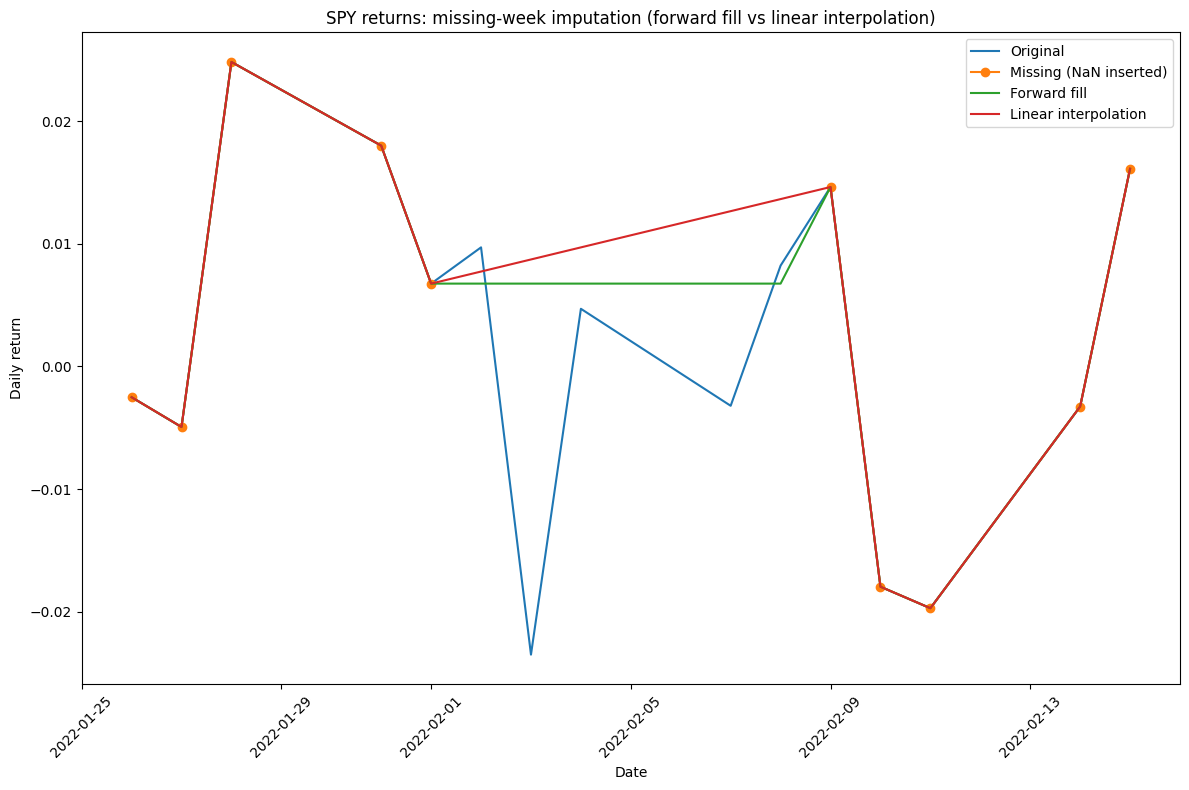

Random week (dates set to NaN):
[Timestamp('2022-02-02 00:00:00'), Timestamp('2022-02-03 00:00:00'), Timestamp('2022-02-04 00:00:00'), Timestamp('2022-02-07 00:00:00'), Timestamp('2022-02-08 00:00:00')]


In [38]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    # Make a copy so we do not modify the original DataFrame
    df = usa.copy()

    # Ensure date is datetime and sort so time operations behave correctly
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values(["ticker", "date"]).reset_index(drop=True)

    # 1 Start from SPY returns
    # If 'ret' is missing (or all NaN), compute returns from close prices
    if "ret" not in df.columns or df["ret"].isna().all():
        df["ret"] = df.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Extract SPY returns as a time series indexed by date
    spy = (
        df[df["ticker"] == "SPY"][["date", "ret"]]
          .dropna(subset=["ret"])
          .sort_values("date")
          .set_index("date")["ret"]
    )

    # Safety check: need enough observations to pick a full 5-business-day week
    if spy.shape[0] < 30:
        print("Not enough SPY observations to sample a random week safely.")
    else:
        # 2 Set returns to NaN for all dates in one random week
        # We sample a random start position and take 5 consecutive observations (approx. one trading week)
        rng = np.random.default_rng(123)  # fixed seed for reproducibility
        start_idx = int(rng.integers(5, spy.shape[0] - 5))
        week_idx = spy.index[start_idx:start_idx + 5]  # 5 consecutive trading days

        # Create a copy and "delete" returns for that week by setting them to NaN
        spy_missing = spy.copy()
        spy_missing.loc[week_idx] = np.nan

        # 3 Impute missing values
        # Forward fill: replace NaN with the last observed value before the gap
        spy_ffill = spy_missing.ffill()

        # Linear interpolation: fill NaN by interpolating between surrounding non-missing values
        spy_lin = spy_missing.interpolate(method="time")

        # 4 Compare imputations over that week using a line plot
        # Build a small DataFrame for plotting just around the selected week
        window = spy.index[max(0, start_idx - 5): start_idx + 10]  # a little context around the week

        comp = pd.DataFrame({
            "original": spy.loc[window],
            "missing": spy_missing.loc[window],
            "ffill": spy_ffill.loc[window],
            "linear_interp": spy_lin.loc[window],
        })

        plt.figure()
        plt.plot(comp.index, comp["original"], label="Original")
        plt.plot(comp.index, comp["missing"], label="Missing (NaN inserted)", marker="o")
        plt.plot(comp.index, comp["ffill"], label="Forward fill")
        plt.plot(comp.index, comp["linear_interp"], label="Linear interpolation")

        plt.title("SPY returns: missing-week imputation (forward fill vs linear interpolation)")
        plt.xlabel("Date")
        plt.ylabel("Daily return")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        print("Random week (dates set to NaN):")
        print(list(week_idx))

### Exercise 1.5 — Standardization and visualization (Lecture 4 II 1.2.5 idea)
Standardize multiple price series and visualize on one scale.

**Tasks**
1. Build a wide price table for SPY, TLT, GLD with dates aligned.
2. Standardize each series (z-score).
3. Plot the standardized series in one figure with legend and title.

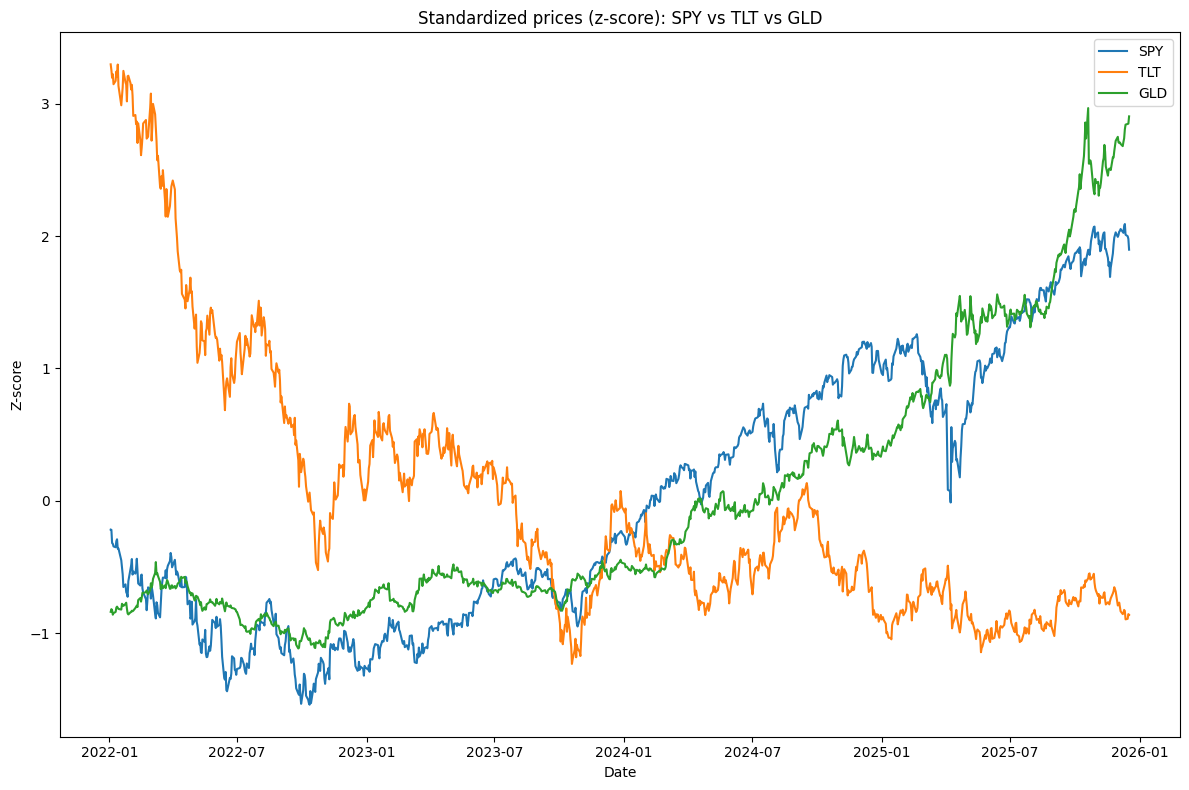

ticker,date,GLD,SPY,TLT
0,2022-01-03,-0.839813,-0.218562,3.297796
1,2022-01-04,-0.819709,-0.220309,3.253609
2,2022-01-05,-0.827978,-0.320470,3.196167
3,2022-01-06,-0.861537,-0.325276,3.223415
4,2022-01-07,-0.849216,-0.345483,3.147562


In [39]:

if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    df = usa.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["close"] = pd.to_numeric(df["close"], errors="coerce")

    # 1 Build a wide PRICE table for SPY, TLT, GLD with aligned dates
    usa_w = (
        df[df["ticker"].isin(["SPY", "TLT", "GLD"])][["date", "ticker", "close"]]
          .dropna(subset=["date", "close"])
          .pivot_table(index="date", columns="ticker", values="close", aggfunc="last")
          .sort_index()
          .reset_index()
    )

    if usa_w.shape[0] == 0:
        print("USA wide table is empty after filtering/pivot.")
    else:
        # 2 Standardize each series (z-score)
        z = usa_w.copy()
        for col in ["SPY", "TLT", "GLD"]:
            x = pd.to_numeric(z[col], errors="coerce")
            z[col] = (x - x.mean()) / x.std(ddof=0)

        # 3 Plot standardized series together
        plt.figure()
        plt.plot(z["date"], z["SPY"], label="SPY")
        plt.plot(z["date"], z["TLT"], label="TLT")
        plt.plot(z["date"], z["GLD"], label="GLD")
        plt.title("Standardized prices (z-score): SPY vs TLT vs GLD")
        plt.xlabel("Date")
        plt.ylabel("Z-score")
        plt.legend()
        plt.tight_layout()
        plt.show()

        display(z.head())

## 2) Online Data Sources 

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [40]:
from pathlib import Path
import time
import requests

def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

    # Warm-up request to get cookies (can help with WAF/403)
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) Recreate the API URL string used to download the Peru series
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")


BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

In [41]:
if "peru_w" not in globals():
    if "peru" not in globals() or peru.shape[0] == 0:
        print("peru_w is not defined, and 'peru' is missing or empty. Run the data download cell first.")
        peru_w = pd.DataFrame()
    else:
        p = peru.copy()
        p["date"] = pd.to_datetime(p["date"], errors="coerce")
        p["value"] = pd.to_numeric(p["value"], errors="coerce")

        peru_w = (
            p.dropna(subset=["date"])
             .pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
             .sort_index()
             .reset_index()
        )
# 
# Build a clean wide table 

if peru_w.shape[0] == 0:
    print("Peru wide table is empty.")
else:
    w = peru_w.copy()

    # Ensure date is a proper column and datetime
    if "date" not in w.columns and w.index.name == "date":
        w = w.reset_index()

    w["date"] = pd.to_datetime(w["date"], errors="coerce")
    w = w.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    # Rename columns to short names (based on long labels)
    rename_map = {}
    for c in w.columns:
        cl = str(c).lower()
        if "tipo de cambio" in cl and "interbanc" in cl:
            rename_map[c] = "fx_interbank"
        elif "tipo de cambio" in cl and "sbs" in cl:
            rename_map[c] = "fx_sbs"
        elif ("oro" in cl) or ("gold" in cl):
            rename_map[c] = "gold"
        elif ("cobre" in cl) or ("copper" in cl):
            rename_map[c] = "copper"

    w = w.rename(columns=rename_map)

    needed = ["fx_interbank", "fx_sbs", "gold", "copper"]
    missing = [c for c in needed if c not in w.columns]

    if missing:
        print("Missing columns after renaming:", missing)
        print("Available columns:", list(w.columns))
    else:
        out = w[["date"] + needed].copy()

        # Ensure numeric
        for c in needed:
            out[c] = pd.to_numeric(out[c], errors="coerce")

        # Daily percentage changes (returns)
        for c in needed:
            out[f"{c}_ret"] = out[c].pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)

        # Drop rows where all four returns are missing
        ret_cols = [f"{c}_ret" for c in needed]
        out = out.dropna(subset=ret_cols, how="all").reset_index(drop=True)

        display(out.head())

series_name,date,fx_interbank,fx_sbs,gold,copper,fx_interbank_ret,fx_sbs_ret,gold_ret,copper_ret
0,2022-01-04,3.959500,3.963,1811.40,438.170229,-0.006066,-0.006020,-0.004780,-0.003302
1,2022-01-05,3.952000,3.953,1826.25,443.522619,-0.001894,-0.002523,0.008198,0.012215
2,2022-01-06,3.967167,3.967,1789.35,433.861102,0.003838,0.003542,-0.020205,-0.021784
3,2022-01-07,3.945167,3.948,1792.60,436.129064,-0.005546,-0.004790,0.001816,0.005227
4,2022-01-10,3.927667,3.925,1794.20,438.397026,-0.004436,-0.005826,0.000893,0.005200


## 3) Matplotlib: Constructing the Plot 

### Exercise 3.1 
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

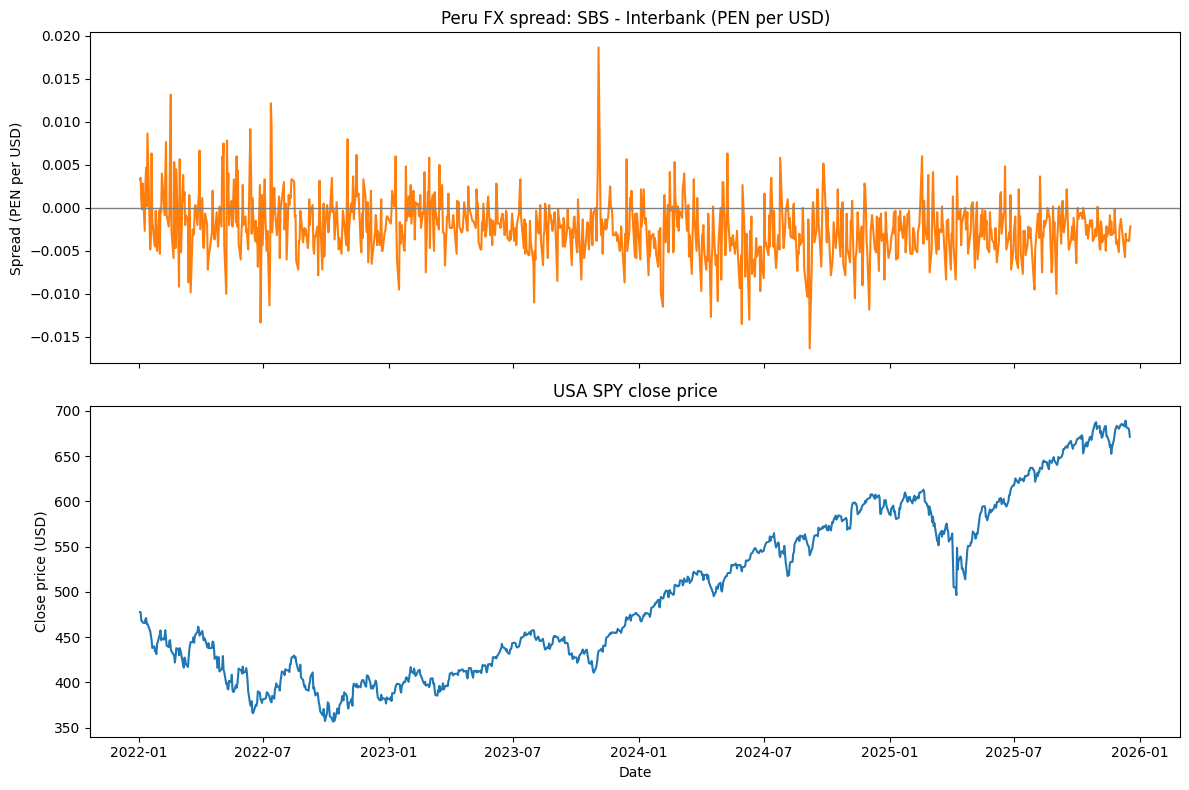

In [42]:
if peru_w.shape[0] == 0 or usa_w.shape[0] == 0:
    print("Missing Peru or USA wide tables.")
else:
    p = peru_w.copy()
    u = usa_w.copy()

    # Ensure date column exists
    if "date" not in p.columns and p.index.name and str(p.index.name).lower() in {"date", "datetime"}:
        p = p.reset_index()
    if "date" not in u.columns and u.index.name and str(u.index.name).lower() in {"date", "datetime"}:
        u = u.reset_index()

    # Standardize date column name
    for df in [p, u]:
        for c in list(df.columns):
            if str(c).lower() in {"date", "datetime"} and c != "date":
                df.rename(columns={c: "date"}, inplace=True)

    # Parse dates and sort
    p["date"] = pd.to_datetime(p["date"], errors="coerce")
    u["date"] = pd.to_datetime(u["date"], errors="coerce")
    p = p.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    u = u.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    # Detect FX columns
    cols_lower = {c: str(c).lower() for c in p.columns}
    def pick_col_contains(*keywords):
        for c, cl in cols_lower.items():
            if all(k in cl for k in keywords):
                return c
        return None

    c_interbank = pick_col_contains("interbanc") or pick_col_contains("interbank")
    c_sbs       = pick_col_contains("sbs")

    if c_interbank is None or c_sbs is None:
        print("Could not find FX columns in peru_w.")
        print("Available Peru columns:", list(p.columns))
    elif "SPY" not in u.columns:
        print("Column 'SPY' not found in usa_w.")
        print("Available USA columns:", list(u.columns))
    else:
        fx = p[["date", c_interbank, c_sbs]].copy()
        fx[c_interbank] = pd.to_numeric(fx[c_interbank], errors="coerce")
        fx[c_sbs] = pd.to_numeric(fx[c_sbs], errors="coerce")
        fx["fx_spread"] = fx[c_sbs] - fx[c_interbank]
        fx_spread = fx[["date", "fx_spread"]].dropna().sort_values("date")

        spy = u[["date", "SPY"]].copy()
        spy["SPY"] = pd.to_numeric(spy["SPY"], errors="coerce")
        spy = spy.dropna().sort_values("date")

        # Subplots with distinct colors
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

        # Top: Peru FX spread 
        axes[0].plot(fx_spread["date"], fx_spread["fx_spread"], color="tab:orange")
        axes[0].set_title("Peru FX spread: SBS - Interbank (PEN per USD)")
        axes[0].set_ylabel("Spread (PEN per USD)")
        axes[0].axhline(0, linewidth=1, color="gray")  

        # Bottom: SPY close 
        axes[1].plot(spy["date"], spy["SPY"], color="tab:blue")
        axes[1].set_title("USA SPY close price")
        axes[1].set_xlabel("Date")
        axes[1].set_ylabel("Close price (USD)")

        fig.tight_layout()
        plt.show()


### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

Largest |SPY ret| date: 2025-04-09 | return: 0.10501930183911301


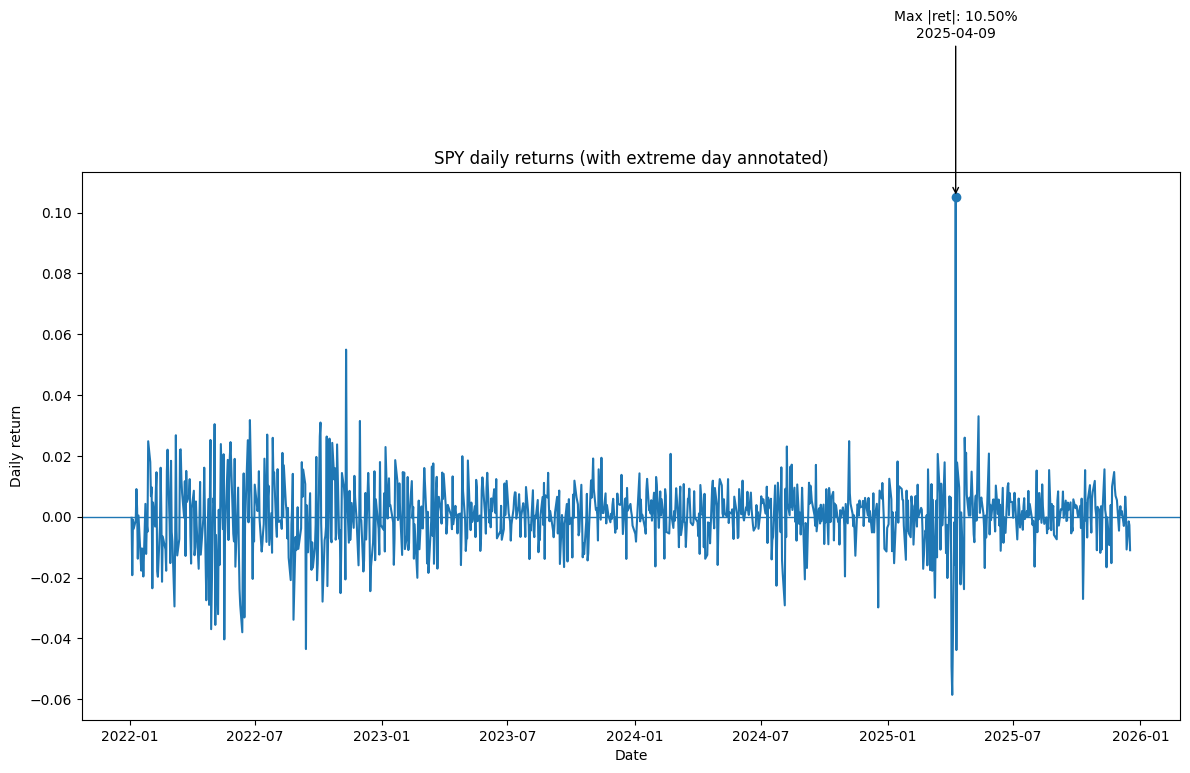

In [43]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    df = usa.copy()

    # Ensure date is datetime
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Keep only SPY rows and sort by date
    spy = df[df["ticker"] == "SPY"].copy()
    spy = spy.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    # Ensure 'ret' exists (compute from close if missing)
    if "ret" not in spy.columns or spy["ret"].isna().all():
        spy["close"] = pd.to_numeric(spy["close"], errors="coerce")
        spy["ret"] = spy["close"].pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)

    # Drop missing returns
    spy = spy.dropna(subset=["ret"]).reset_index(drop=True)

    if spy.shape[0] == 0:
        print("No SPY returns available.")
    else:
        # 1 Find the date with the largest absolute daily return
        idx = spy["ret"].abs().idxmax()
        event_date = spy.loc[idx, "date"]
        event_ret = float(spy.loc[idx, "ret"])

        print("Largest |SPY ret| date:", event_date.date(), "| return:", event_ret)

        # 2 Plot SPY returns over time
        plt.figure()
        plt.plot(spy["date"], spy["ret"])
        plt.title("SPY daily returns (with extreme day annotated)")
        plt.xlabel("Date")
        plt.ylabel("Daily return")

        # 3 Add annotation (arrow + text) at the extreme point
        label = f"Max |ret|: {event_ret:.2%}\n{event_date.date()}"
        plt.scatter([event_date], [event_ret], zorder=3)  

        plt.annotate(
            label,
            xy=(event_date, event_ret),           
            xytext=(event_date, event_ret * 1.5), 
            arrowprops=dict(arrowstyle="->"),
            ha="center"
        )

        plt.axhline(0, linewidth=1)
        plt.tight_layout()
        plt.show()

### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [44]:
# 1 Create the folder if it does not exist
fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)

# 2 Save the specific figure object (recommended)
out_path = fig_dir / "lecture4II_fx_spy.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")

# 3 Confirm the file exists
print("Saved to:", out_path)
print("File exists?", out_path.exists())

plt.close(fig)

Saved to: figures/lecture4II_fx_spy.png
File exists? True


## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [45]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    # Make a working copy (do not modify the original 'usa') ---
    df = usa.copy()

    # Ensure correct dtypes ---
    df["date"] = pd.to_datetime(df["date"], errors="coerce")          # parse dates
    df["close"] = pd.to_numeric(df["close"], errors="coerce")         # ensure numeric close

    # Keep only the tickers we need 
    tickers = ["SPY", "TLT", "GLD"]
    df = df[df["ticker"].isin(tickers)].dropna(subset=["date"]).copy()

    # Ensure returns exist (compute if missing/empty) 
    if "ret" not in df.columns or df["ret"].isna().all():
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)        # sort for pct_change
        df["ret"] = df.groupby("ticker")["close"].pct_change(fill_method=None) # daily returns

    # Build a WIDE returns table: rows = date, columns = tickers 
    ret_w = (
        df[["date", "ticker", "ret"]]
        .dropna(subset=["ret"])
        .pivot_table(index="date", columns="ticker", values="ret", aggfunc="last")
        .sort_index()
    )

    # Compute moments for each ticker/column 
    stats = pd.DataFrame({
        "mean": ret_w.mean(skipna=True),
        "std": ret_w.std(skipna=True),
        "skewness": ret_w.skew(skipna=True),
        "kurtosis": ret_w.kurt(skipna=True),  
    })

    # Clean presentation 
    stats.index.name = "ticker"
    stats = stats.loc[tickers]  

    display(ret_w.head())
    display(stats)

ticker,GLD,SPY,TLT
date,,,
2022-01-04,0.007367,-0.000335,-0.004158
2022-01-05,-0.003008,-0.019202,-0.005428
2022-01-06,-0.012244,-0.000939,0.002589
2022-01-07,0.004551,-0.003954,-0.007188
2022-01-10,0.003040,-0.001244,0.002460


,mean,std,skewness,kurtosis
ticker,,,,
SPY,0.000408,0.011408,0.370137,9.031124
TLT,-0.000446,0.010441,0.014346,0.372478
GLD,0.000920,0.010029,-0.196324,2.401211


### Exercise 4.2 — 
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

OLS (closed-form) results
alpha: 0.0008789945468910875
beta : 0.10180354086179287
N    : 993


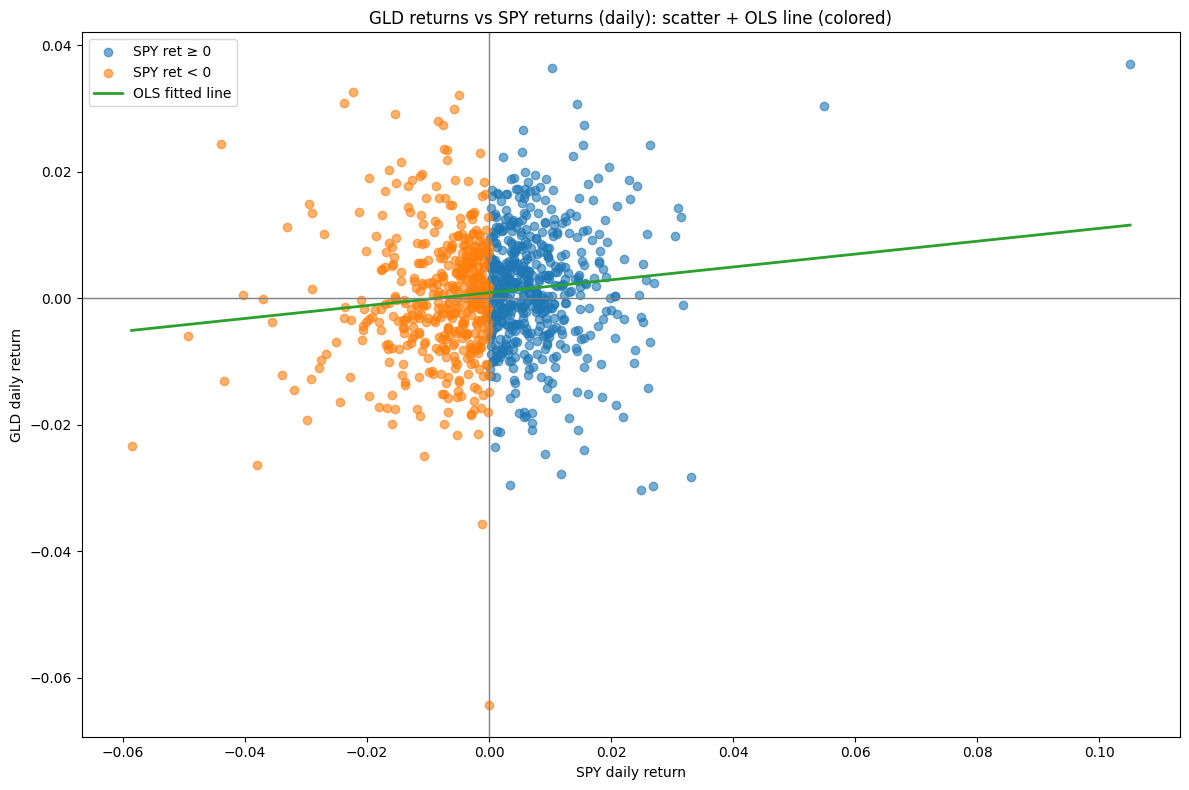

In [46]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else:
    df = usa.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["close"] = pd.to_numeric(df["close"], errors="coerce")

    # Keep only SPY and GLD
    df = df[df["ticker"].isin(["SPY", "GLD"])].dropna(subset=["date"]).copy()

    # Compute returns if missing
    if "ret" not in df.columns or df["ret"].isna().all():
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
        df["ret"] = df.groupby("ticker")["close"].pct_change(fill_method=None)

    # Align returns by date (wide)
    ret_w = (
        df[["date", "ticker", "ret"]]
        .dropna(subset=["ret"])
        .pivot_table(index="date", columns="ticker", values="ret", aggfunc="last")
        .sort_index()
    )
    aligned = ret_w.dropna(subset=["SPY", "GLD"]).copy()

    x = aligned["SPY"].to_numpy()  # SPY returns
    y = aligned["GLD"].to_numpy()  # GLD returns

    if len(x) < 5:
        print("Not enough overlapping observations for regression.")
    else:
        # Closed-form OLS
        x_mean = x.mean()
        y_mean = y.mean()
        cov_xy = np.mean((x - x_mean) * (y - y_mean))
        var_x  = np.mean((x - x_mean) ** 2)

        beta = cov_xy / var_x
        alpha = y_mean - beta * x_mean

        print("OLS (closed-form) results")
        print("alpha:", alpha)
        print("beta :", beta)
        print("N    :", len(x))

        # Color points by SPY sign
        pos = x >= 0
        neg = ~pos

        plt.figure()
        plt.scatter(x[pos], y[pos], alpha=0.6, label="SPY ret ≥ 0", color="tab:blue")
        plt.scatter(x[neg], y[neg], alpha=0.6, label="SPY ret < 0", color="tab:orange")

        # Fitted line
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = alpha + beta * x_line
        plt.plot(x_line, y_line, linewidth=2, label="OLS fitted line", color="tab:green")

        plt.axhline(0, linewidth=1, color="gray")
        plt.axvline(0, linewidth=1, color="gray")
        plt.title("GLD returns vs SPY returns (daily): scatter + OLS line (colored)")
        plt.xlabel("SPY daily return")
        plt.ylabel("GLD daily return")
        plt.legend()
        plt.tight_layout()
        plt.show()

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [47]:
if usa.shape[0] == 0:
    print("USA data is empty.")
else :  
    df = usa.copy()
    
    df["date"] = pd.to_datetime(df["date"], errors="coerce")          
    df["close"] = pd.to_numeric(df["close"], errors="coerce") 
        # Keep only SPY and TLT
    df = df[df["ticker"].isin(["SPY", "TLT"])].dropna(subset=["date"]).copy()

    # If returns are missing, compute them per ticker (daily % change in close)
    if "ret" not in df.columns or df["ret"].isna().all():
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)           # Sort for pct_change
        df["ret"] = df.groupby("ticker")["close"].pct_change(fill_method=None)   # Daily returns
    # 1. Wide returns table for SPY and TLT

    ret_w = (
        df[["date", "ticker", "ret"]]
        .dropna(subset=["ret"])
        .pivot_table(index="date", columns="ticker", values="ret", aggfunc="last")
        .sort_index()
    )

    # Keep only days with both returns available (aligned)
    ret_w = ret_w.dropna(subset=["SPY", "TLT"]).copy()

    if ret_w.shape[0] == 0:
        print("No overlapping SPY/TLT return dates after cleaning.")
    else:
        # 2. Portfolio daily returns: 60% SPY + 40% TLT

        w_spy = 0.60
        w_tlt = 0.40
        ret_w["port_ret"] = w_spy * ret_w["SPY"] + w_tlt * ret_w["TLT"]

        # 3. 1-day 95% Historical VaR VaR_95 (historical) = 5th percentile of returns

        q = 0.05
        var_95 = ret_w["port_ret"].quantile(q)  

        # 4. 1-day 95% CVaR (Expected Shortfall) CVaR_95 = average return in the worst 5% tail (returns <= VaR threshold)

        tail = ret_w.loc[ret_w["port_ret"] <= var_95, "port_ret"]
        cvar_95 = tail.mean()

        # Print results (returns form, not dollars)
        print("Obs (aligned days):", ret_w.shape[0])
        print("1-day 95% Historical VaR (5th pct):", var_95)
        print("1-day 95% CVaR (mean below VaR):   ", cvar_95)
        print("Tail obs (worst 5%):", tail.shape[0])

        display(ret_w[["SPY", "TLT", "port_ret"]].head())

Obs (aligned days): 993
1-day 95% Historical VaR (5th pct): -0.013703131391403734
1-day 95% CVaR (mean below VaR):    -0.018592606080486598
Tail obs (worst 5%): 50


ticker,SPY,TLT,port_ret
date,,,
2022-01-04,-0.000335,-0.004158,-0.001864
2022-01-05,-0.019202,-0.005428,-0.013692
2022-01-06,-0.000939,0.002589,0.000472
2022-01-07,-0.003954,-0.007188,-0.005247
2022-01-10,-0.001244,0.002460,0.000238


## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance

# Time Series & Kernel PCA

In [48]:
# If you need dependencies (run once):
# !pip install -U yfinance scikit-learn statsmodels matplotlib pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline


The Dow Jones Industrial Average and Its 30 Components
Downloading Dow componentms datasets

In [49]:
SYMBOLS = [
    "AAPL","MMM","AXP","BA","CAT",
    "CVX","CSCO","KO","DD","XOM",
    "GS","HD","IBM","INTC","JNJ",
    "JPM","MCD","MRK","MSFT","NKE",
    "PFE","PG","UNH","UTX","TRV",
    "VZ","V","WMT","WBA","DIS",
]

raw = yf.download(
    tickers=SYMBOLS,
    start="2017-01-01",
    end="2018-01-01",   # end is exclusive -> includes all of 2017
    auto_adjust=False,
    progress=False
)

# Extract Adjusted Close into a (dates x tickers) DataFrame
if isinstance(raw.columns, pd.MultiIndex):
    df_components = raw["Adj Close"].copy()
else:
    df_components = raw[["Adj Close"]].copy()

# Ensure column order and names match SYMBOLS
df_components = df_components.reindex(columns=SYMBOLS)

# Drop tickers that are entirely missing (all-NaN)
all_nan_cols = df_components.columns[df_components.isna().all()].tolist()
if all_nan_cols:
    print("Dropping all-NaN tickers:", all_nan_cols)
    df_components = df_components.drop(columns=all_nan_cols)

df_components.head()



2 Failed downloads:
['WBA', 'UTX']: YFTzMissingError('possibly delisted; no timezone found')


Dropping all-NaN tickers: ['UTX', 'WBA']


Ticker,AAPL,MMM,AXP,BA,CAT,CVX,CSCO,KO,DD,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,UNH,TRV,VZ,V,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,26.770882,109.918259,66.532211,145.533707,76.607162,80.250076,23.215670,31.518011,28.428946,60.723438,199.930847,108.098213,108.518166,29.879774,90.299980,68.519814,96.660248,43.497284,56.299309,46.297920,21.111748,66.057152,139.939758,99.347755,33.851612,74.684143,19.629131,99.247139
2017-01-04,26.740917,110.084953,67.622917,147.063446,76.264832,80.229668,23.077662,31.404915,28.655996,60.055344,201.221954,109.055984,109.861717,29.724659,90.151863,68.646202,96.547134,43.482826,56.047401,47.268768,21.297270,66.292526,140.338470,98.813675,33.814388,75.294754,19.743490,100.519547
2017-01-05,26.876909,109.708344,66.789352,147.146896,75.800285,79.882378,23.131330,31.480316,28.527657,59.160091,199.723892,107.768227,109.498199,29.675678,91.095100,68.014320,96.724884,43.468353,56.047401,47.259865,21.501995,66.731842,140.572464,97.235916,33.888802,76.177849,19.786366,100.463409
2017-01-06,27.176537,110.029404,66.922356,147.508484,75.832893,79.562325,23.177328,31.472773,28.349977,59.126682,202.686859,107.470444,110.037010,29.781809,90.658562,68.022194,97.581451,43.584064,56.533222,48.016960,21.418829,66.708336,140.771835,97.186623,33.386074,77.229980,19.514776,101.960350
2017-01-09,27.425459,109.436752,67.268158,146.785309,75.286774,78.881393,23.138996,31.156082,28.522728,58.151268,201.023285,108.098213,108.816711,29.887936,90.642982,68.069603,97.314796,44.184269,56.353294,47.544872,21.412432,66.214066,140.373123,96.405983,33.022503,76.797829,19.643433,101.380287


Forward-fill missing values, resample to daily (calendar days), then back-fill any initial gaps.

In [50]:
filled_df_components = df_components.ffill()

daily_df_components = (
    filled_df_components
    .resample("1D").ffill()
    .bfill()
)

daily_df_components.head()


Ticker,AAPL,MMM,AXP,BA,CAT,CVX,CSCO,KO,DD,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,UNH,TRV,VZ,V,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,26.770882,109.918259,66.532211,145.533707,76.607162,80.250076,23.215670,31.518011,28.428946,60.723438,199.930847,108.098213,108.518166,29.879774,90.299980,68.519814,96.660248,43.497284,56.299309,46.297920,21.111748,66.057152,139.939758,99.347755,33.851612,74.684143,19.629131,99.247139
2017-01-04,26.740917,110.084953,67.622917,147.063446,76.264832,80.229668,23.077662,31.404915,28.655996,60.055344,201.221954,109.055984,109.861717,29.724659,90.151863,68.646202,96.547134,43.482826,56.047401,47.268768,21.297270,66.292526,140.338470,98.813675,33.814388,75.294754,19.743490,100.519547
2017-01-05,26.876909,109.708344,66.789352,147.146896,75.800285,79.882378,23.131330,31.480316,28.527657,59.160091,199.723892,107.768227,109.498199,29.675678,91.095100,68.014320,96.724884,43.468353,56.047401,47.259865,21.501995,66.731842,140.572464,97.235916,33.888802,76.177849,19.786366,100.463409
2017-01-06,27.176537,110.029404,66.922356,147.508484,75.832893,79.562325,23.177328,31.472773,28.349977,59.126682,202.686859,107.470444,110.037010,29.781809,90.658562,68.022194,97.581451,43.584064,56.533222,48.016960,21.418829,66.708336,140.771835,97.186623,33.386074,77.229980,19.514776,101.960350
2017-01-07,27.176537,110.029404,66.922356,147.508484,75.832893,79.562325,23.177328,31.472773,28.349977,59.126682,202.686859,107.470444,110.037010,29.781809,90.658562,68.022194,97.581451,43.584064,56.533222,48.016960,21.418829,66.708336,140.771835,97.186623,33.386074,77.229980,19.514776,101.960350


In [51]:
df = yf.download(
    "NDAQ",
    period="max",
    auto_adjust=False,
    progress=False
)

df = df[["Adj Close"]].rename(columns={"Adj Close": "5. adjusted close"})
df.index = pd.to_datetime(df.index)
df.index.name = "date"
df = df.sort_index()

# Prepare the dataframe
df_dji = pd.DataFrame(df["5. adjusted close"])
df_dji.columns = ["NDAQ"]

# Trim and resample for 2017
djia_2017 = df_dji.loc["2017"].resample("1D").ffill()

djia_2017.head()


,NDAQ
date,
2017-01-03,19.270126
2017-01-04,19.570688
2017-01-05,19.547560
2017-01-06,19.784538
2017-01-07,19.784538


In [52]:
from sklearn.decomposition import KernelPCA

def zscore_safe(s: pd.Series) -> pd.Series:
    """Z-score with a safe fallback for constant/degenerate columns."""
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series(0.0, index=s.index)
    return (s - mu) / sd

def kpca_eigenvalues(model: KernelPCA):
    """Compatibility helper: scikit-learn uses eigenvalues_ (new) vs lambdas_ (old)."""
    if hasattr(model, "eigenvalues_"):
        return model.eigenvalues_
    if hasattr(model, "lambdas_"):
        return model.lambdas_
    raise AttributeError("KernelPCA has no eigenvalues_ or lambdas_. Check your scikit-learn version.")

# Build a clean matrix for KPCA
X = daily_df_components.copy()

# Defensive fill (should already be filled, but keep this robust)
X = X.ffill().bfill()

# Z-score safely
df_z_components = X.apply(zscore_safe)

# Remove any remaining invalid values
df_z_components = df_z_components.replace([np.inf, -np.inf], np.nan)

# Drop columns/rows with NaNs (KPCA requires complete data)
nan_cols = df_z_components.columns[df_z_components.isna().any()].tolist()
if nan_cols:
    print("Dropping tickers with remaining NaNs:", nan_cols)
    df_z_components = df_z_components.drop(columns=nan_cols)

df_z_components = df_z_components.dropna(axis=0)

print("KPCA input shape:", df_z_components.shape)
df_z_components.head()


KPCA input shape: (361, 28)


Ticker,AAPL,MMM,AXP,BA,CAT,CVX,CSCO,KO,DD,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PFE,PG,UNH,TRV,VZ,V,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,-2.304523,-1.518382,-1.341838,-1.414101,-1.091933,0.652133,-1.420687,-1.442824,-1.779462,3.532795,0.553292,-1.657108,0.597021,-0.442031,-1.696786,-0.873065,-1.748396,-0.924243,-1.360654,-1.247676,-1.052284,-2.451975,-1.275039,-0.890118,1.915463,-1.886739,-1.173052,-0.154731
2017-01-04,-2.312920,-1.504595,-1.177958,-1.376288,-1.114091,0.647486,-1.498258,-1.510452,-1.683366,3.059594,0.682575,-1.570238,0.785357,-0.489242,-1.717533,-0.849790,-1.756272,-0.930654,-1.397721,-0.915103,-0.883346,-2.344664,-1.252429,-0.997036,1.892206,-1.820584,-1.131699,0.136817
2017-01-05,-2.274809,-1.535745,-1.303202,-1.374225,-1.144159,0.568411,-1.468092,-1.465364,-1.737684,2.425501,0.532569,-1.687038,0.734400,-0.504150,-1.585410,-0.966150,-1.743895,-0.937072,-1.397721,-0.918153,-0.696921,-2.144375,-1.239160,-1.312889,1.938699,-1.724907,-1.116196,0.123954
2017-01-06,-2.190839,-1.509189,-1.283218,-1.365287,-1.142048,0.495537,-1.442238,-1.469875,-1.812885,2.401837,0.829262,-1.714047,0.809929,-0.471848,-1.646558,-0.964700,-1.684253,-0.885762,-1.326234,-0.658804,-0.772653,-2.155092,-1.227854,-1.322757,1.624598,-1.610917,-1.214403,0.466949
2017-01-07,-2.190839,-1.509189,-1.283218,-1.365287,-1.142048,0.495537,-1.442238,-1.469875,-1.812885,2.401837,0.829262,-1.714047,0.809929,-0.471848,-1.646558,-0.964700,-1.684253,-0.885762,-1.326234,-0.658804,-0.772653,-2.155092,-1.227854,-1.322757,1.624598,-1.610917,-1.214403,0.466949


Applying a Kernel Principal Component Analysis
Finding Eigenvectors and Eigenvalues

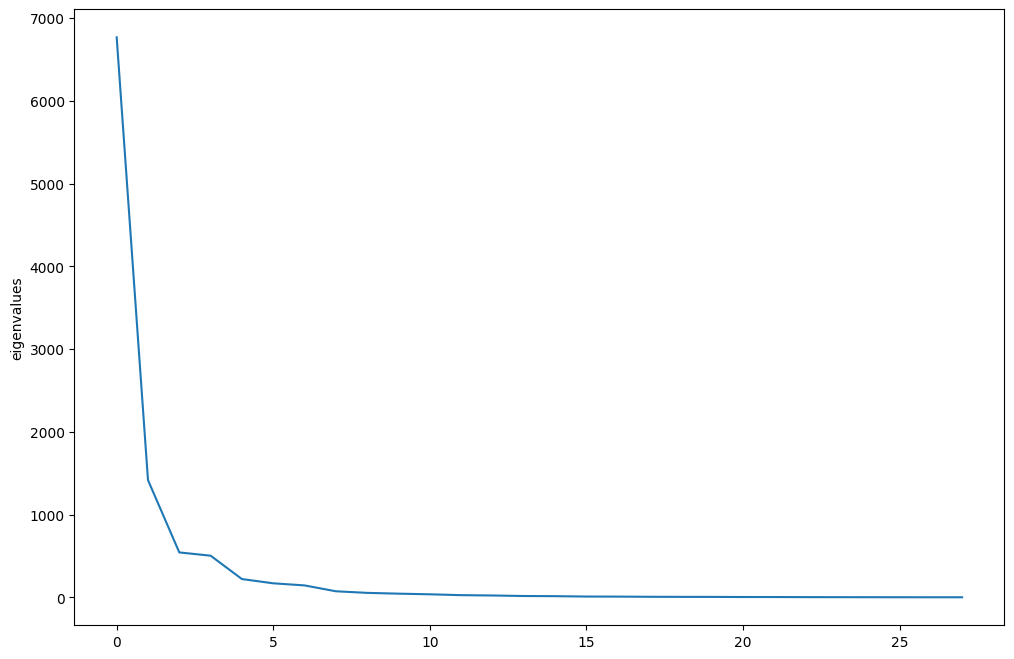

Top 5 eigenvalue weights: [0.66949648 0.14014376 0.05370398 0.04978882 0.02187494]
Sum of top 5 weights: 0.9350079849615479


In [53]:
fitted_pca = KernelPCA().fit(df_z_components)

eigvals = kpca_eigenvalues(fitted_pca)

plt.plot(eigvals)
plt.ylabel("eigenvalues")
plt.show()

weights_all = eigvals / eigvals.sum()
print("Top 5 eigenvalue weights:", weights_all[:5])
print("Sum of top 5 weights:", weights_all[:5].sum())


Reconstructing the Dow Index with PCA

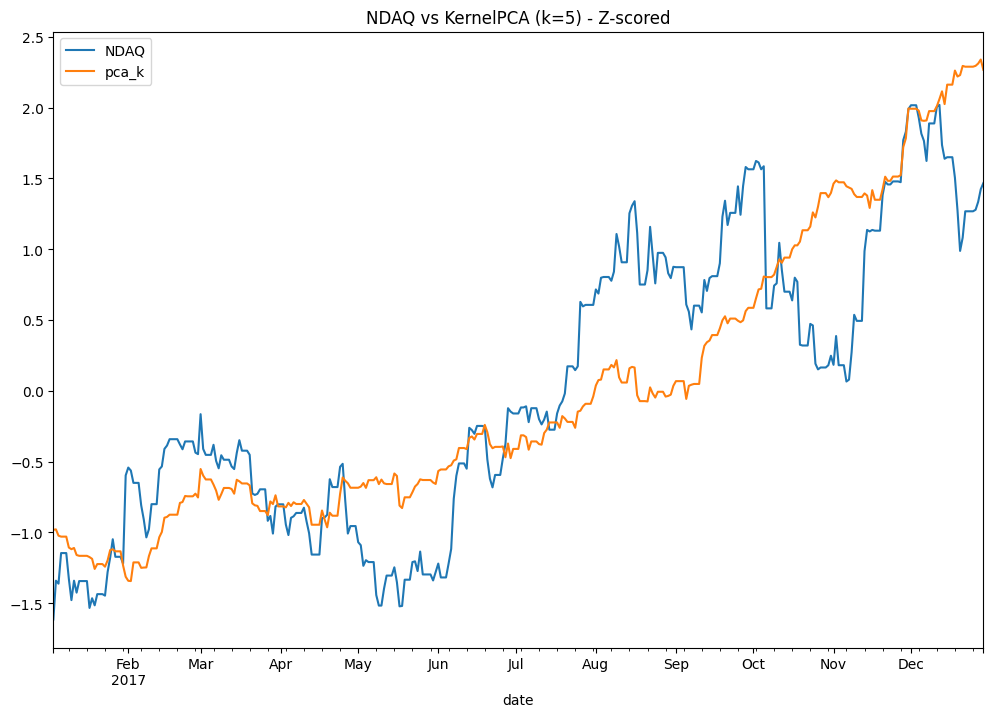

In [54]:
k = min(5, df_z_components.shape[1])
kernel_pca = KernelPCA(n_components=k).fit(df_z_components)
pca_k = kernel_pca.transform(df_z_components)

eigvals_k = kpca_eigenvalues(kernel_pca)
w_k = eigvals_k / eigvals_k.sum()

reconstructed_values = pca_k @ w_k

# Combine and align on dates
df_combined = djia_2017.copy()
df_combined["pca_k"] = pd.Series(reconstructed_values, index=df_z_components.index)

# Keep 2017 only and drop NaNs from alignment
df_combined_2017 = df_combined.loc["2017"].dropna()

# Z-score both series for comparison
df_combined_2017 = df_combined_2017.apply(lambda s: (s - s.mean()) / s.std(ddof=0))

df_combined_2017.plot(figsize=(12, 8), title=f"NDAQ vs KernelPCA (k={k}) - Z-scored");
plt.show()


Analyzing a time series with trend

In [55]:
gold = yf.download(
    "GC=F",
    start="2000-01-01",
    auto_adjust=False,
    progress=False
)

# Use Adj Close as a settlement-like proxy; take month-end values
df_settle = gold["Adj Close"].dropna().resample("M").last()

# Convert to month-start frequency with forward fill (similar to original MS step)
df_settle = df_settle.resample("MS").ffill().dropna()

df_settle.head()


/var/folders/gb/56xms55d53n734tnp7xq55bh0000gq/T/ipykernel_12722/1177750068.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_settle = gold["Adj Close"].dropna().resample("M").last()


Ticker,GC=F
Date,
2000-09-01,278.299988
2000-10-01,273.600006
2000-11-01,264.899994
2000-12-01,270.100006
2001-01-01,272.000000


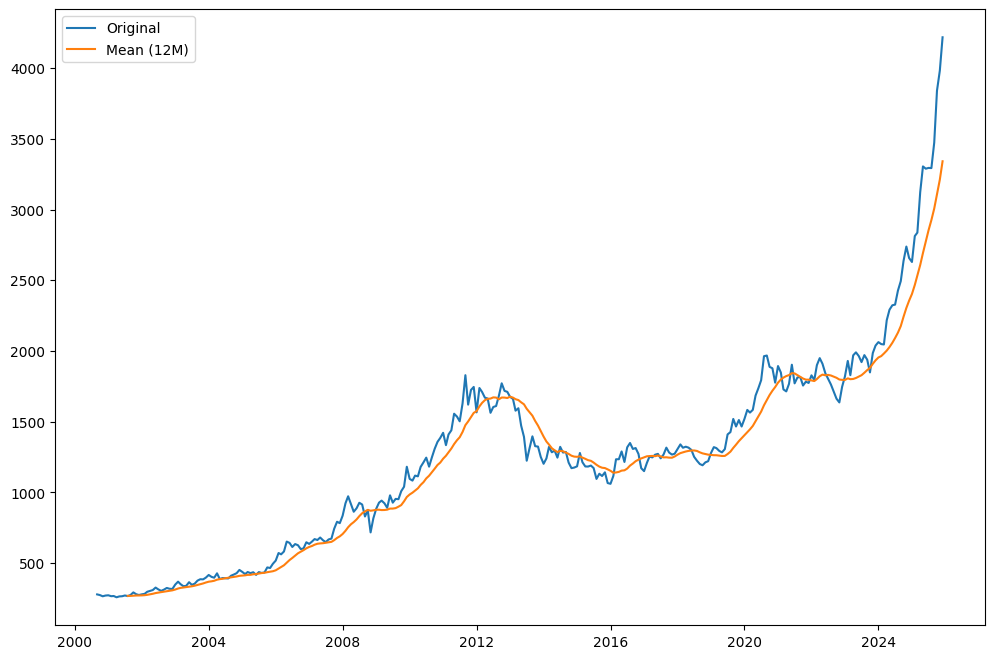

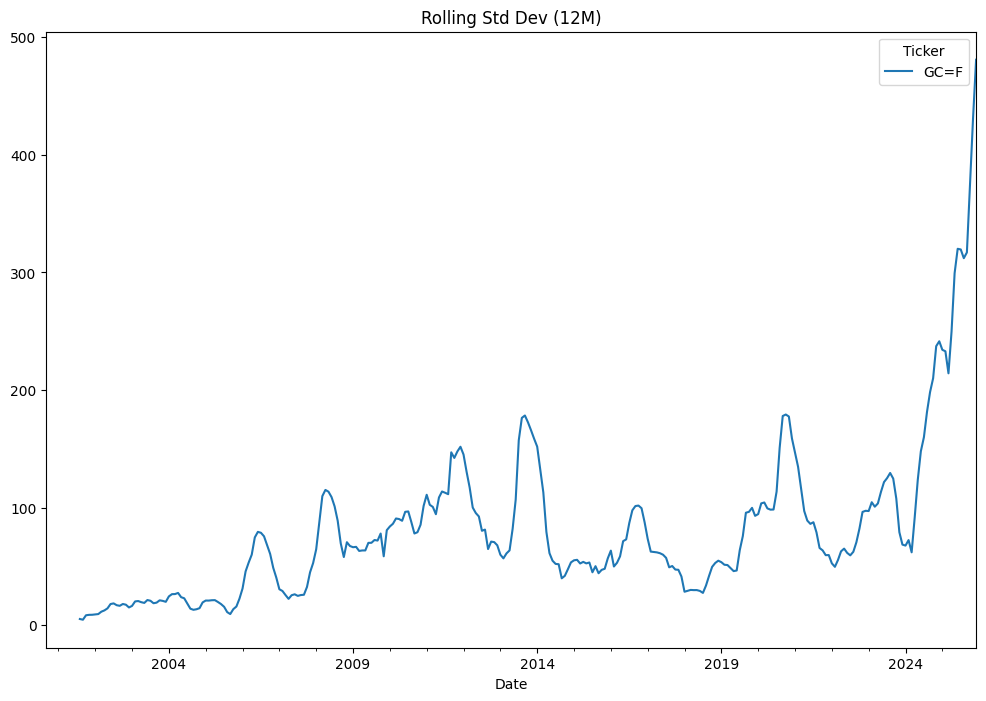

In [56]:
df_mean = df_settle.rolling(12).mean()
df_std  = df_settle.rolling(12).std()

plt.figure(figsize=(12, 8))
plt.plot(df_settle, label="Original")
plt.plot(df_mean, label="Mean (12M)")
plt.legend()
plt.show()

df_std.plot(figsize=(12, 8), title="Rolling Std Dev (12M)")
plt.show()


In [57]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_settle)
print("ADF statistic:", result[0])
print("p-value:", result[1])

for key, value in result[4].items():
    print(f"Critical value ({key}): {value:.3f}")


ADF statistic: 1.8015963632787364
p-value: 0.9983521779296399
Critical value (1%): -3.453
Critical value (5%): -2.872
Critical value (10%): -2.572


Making a time series stationary
Detrending

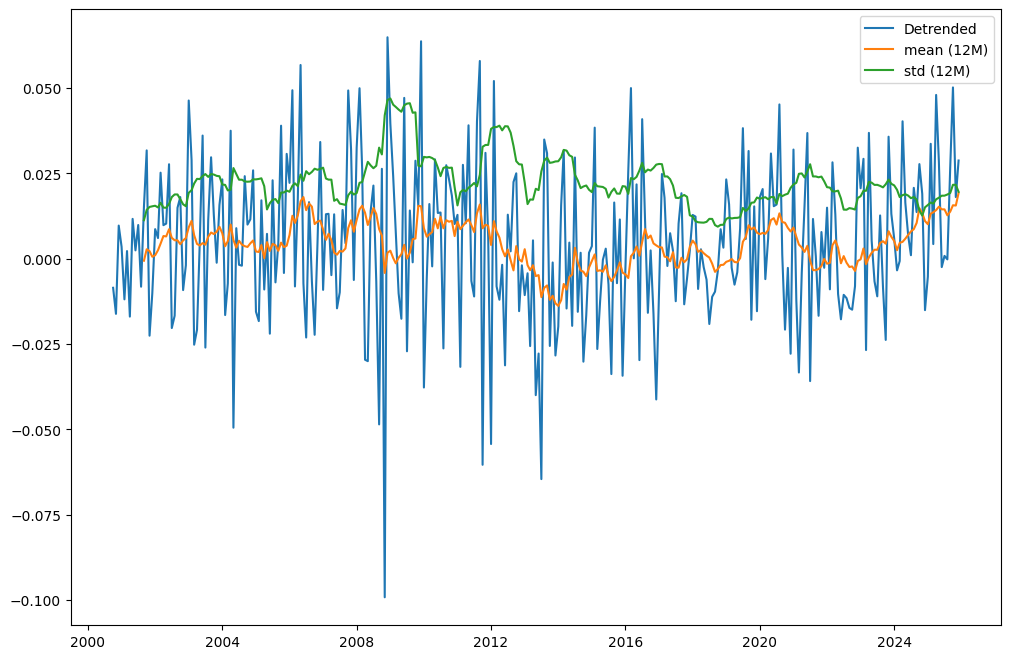

ADF statistic: -18.8910984476087
p-value: 0.00000
Critical value (1%): -3.452
Critical value (5%): -2.871
Critical value (10%): -2.572


In [58]:
df_log = np.log(df_settle)

df_log_ma = df_log.rolling(2).mean()
df_detrend = (df_log - df_log_ma).dropna()

df_detrend_ma = df_detrend.rolling(12).mean()
df_detrend_std = df_detrend.rolling(12).std()

plt.figure(figsize=(12, 8))
plt.plot(df_detrend, label="Detrended")
plt.plot(df_detrend_ma, label="mean (12M)")
plt.plot(df_detrend_std, label="std (12M)")
plt.legend(loc="upper right")
plt.show()

result = adfuller(df_detrend)
print("ADF statistic:", result[0])
print("p-value: %.5f" % result[1])
for key, value in result[4].items():
    print(f"Critical value ({key}): {value:.3f}")


Removing trend by differencing

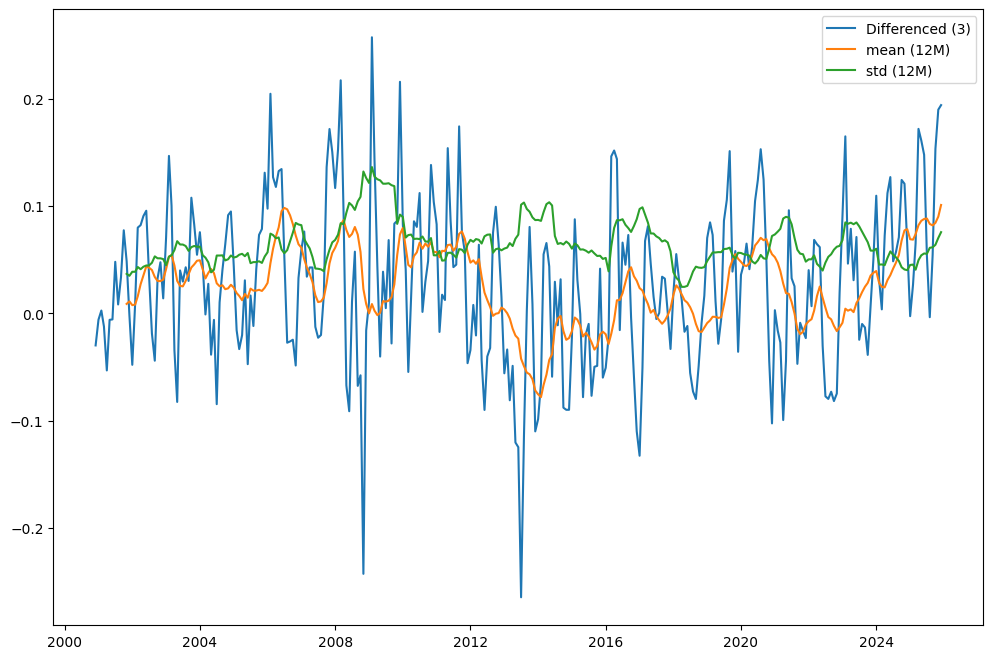

ADF statistic: -2.3043879181388527
p-value: 0.17056
Critical value (1%): -3.454
Critical value (5%): -2.872
Critical value (10%): -2.572


In [59]:
df_log_diff = df_log.diff(periods=3).dropna()

df_diff_ma = df_log_diff.rolling(12).mean()
df_diff_std = df_log_diff.rolling(12).std()

plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label="Differenced (3)")
plt.plot(df_diff_ma, label="mean (12M)")
plt.plot(df_diff_std, label="std (12M)")
plt.legend(loc="upper right")
plt.show()

result = adfuller(df_log_diff)
print("ADF statistic:", result[0])
print("p-value: %.5f" % result[1])
for key, value in result[4].items():
    print(f"Critical value ({key}): {value:.3f}")


Seasonal Decomposing

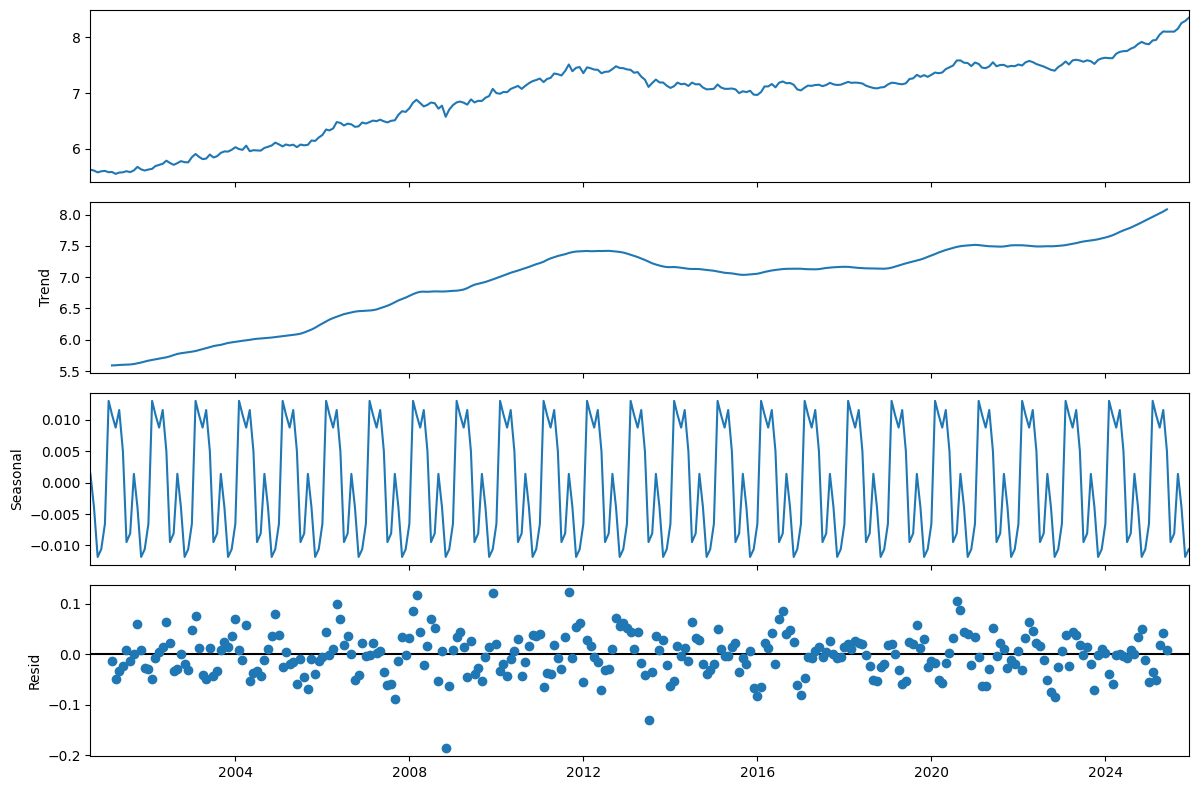

ADF statistic: -7.688947526836548
p-value: 0.00000
Critical value (1%): -3.454
Critical value (5%): -2.872
Critical value (10%): -2.572


In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(df_log.dropna(), period=12)

fig = decompose_result.plot()
plt.show()

df_residual = decompose_result.resid.dropna()

result = adfuller(df_residual)
print("ADF statistic:", result[0])
print("p-value: %.5f" % result[1])
for key, value in result[4].items():
    print(f"Critical value ({key}): {value:.3f}")


Forecasting and Predicting a Time Series
Finding model parameters by grid search

In [61]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(series: pd.Series, s: int = 12):
    p = d = q = range(2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(P, D, Q, s) for (P, D, Q) in itertools.product(p, d, q)]

    lowest_aic = np.inf
    best_order = None
    best_seasonal = None

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(
                    series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = model.fit(maxiter=200, disp=False)
                if res.aic < lowest_aic:
                    lowest_aic = res.aic
                    best_order = order
                    best_seasonal = seasonal_order
            except Exception:
                continue

    return lowest_aic, best_order, best_seasonal

lowest_aic, order, seasonal_order = arima_grid_search(df_settle, s=12)
print(f"Best order: {order}")
print(f"Best seasonal order: {seasonal_order}")
print(f"Lowest AIC: {lowest_aic:.3f}")


Best order: (1, 1, 1)
Best seasonal order: (0, 1, 1, 12)
Lowest AIC: 3148.995


Fitting the SARIMAX model

                                     SARIMAX Results                                      
Dep. Variable:                               GC=F   No. Observations:                  304
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1570.498
Date:                            Mon, 29 Dec 2025   AIC                           3148.995
Time:                                    15:45:47   BIC                           3163.491
Sample:                                09-01-2000   HQIC                          3154.812
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0146      0.023     44.585      0.000       0.970       1.059
ma.L1         -0.9335      0.041   

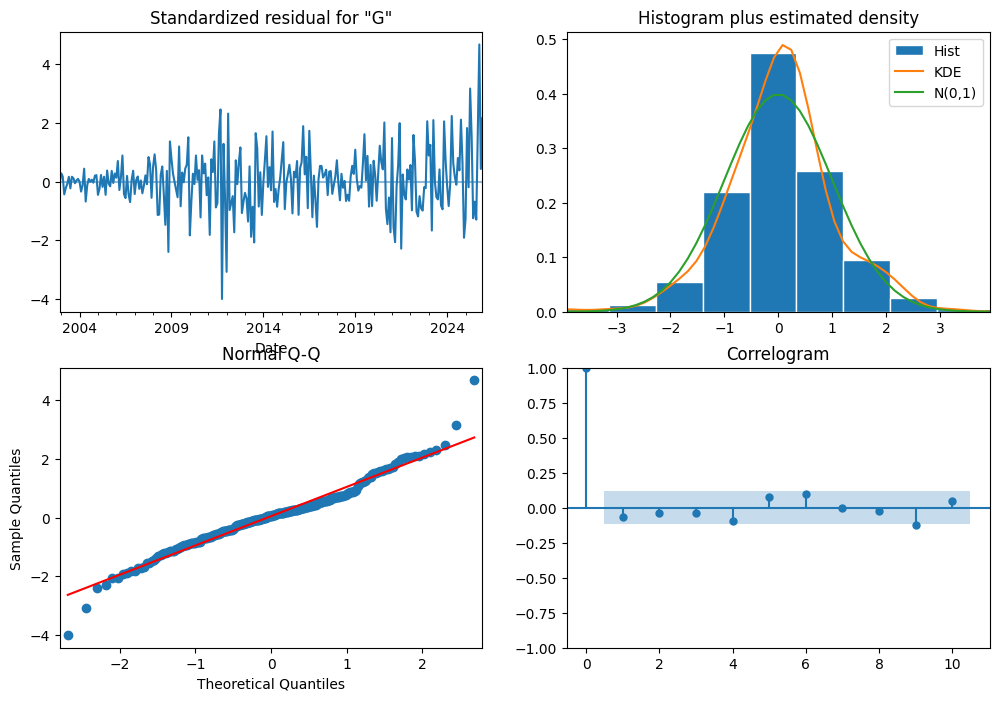

count    304.000000
mean       3.119145
std       69.268824
min     -277.428317
25%      -33.668410
50%        3.026295
75%       34.332352
max      320.257203
dtype: float64

In [62]:
model = SARIMAX(
    df_settle,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_results = model.fit(maxiter=200, disp=False)

print(model_results.summary())

model_results.plot_diagnostics(figsize=(12, 8))
plt.show()

model_results.resid.describe()


Predicting the model

             lower GC=F   upper GC=F
2021-01-01  1657.058432  1925.671039
2021-02-01  1819.017811  2087.626260
2021-03-01  1735.370563  2003.975392


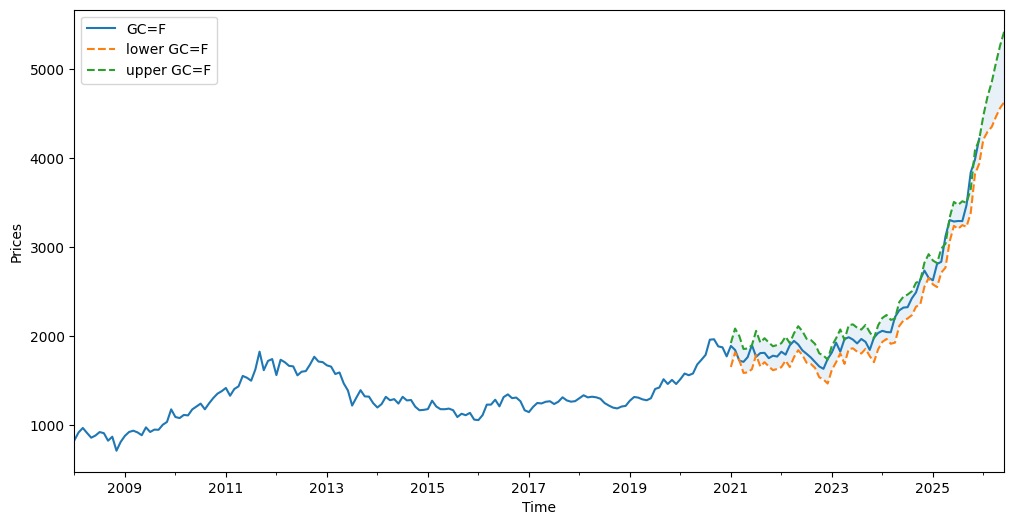

In [63]:
n = len(df_settle)

prediction = model_results.get_prediction(
    start=n - 12*5,  # last 5 years (monthly)
    end=n + 5        # a few steps ahead
)
prediction_ci = prediction.conf_int()

print(prediction_ci.head(3))

ax = df_settle["2008":].plot(label="actual", figsize=(12, 6))

# Plot CI bounds
prediction_ci.plot(ax=ax, style=["--", "--"], label="predicted/forecasted")

lower_ci = prediction_ci.iloc[:, 0].values
upper_ci = prediction_ci.iloc[:, 1].values
ci_index = prediction_ci.index

ax.fill_between(ci_index, lower_ci, upper_ci, alpha=0.1)

ax.set_xlabel("Time")
ax.set_ylabel("Prices")
plt.legend()
plt.show()
